In [1]:
import torch
import numpy as np
import cv2
import os
import random as rand
import torchvision
import pandas as pd
from tqdm import tqdm
from torch import nn, Tensor
import matplotlib.pyplot as plt
from typing import Optional
from torch.nn import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from math import ceil
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

/home/s25090/miniconda3/envs/discovr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CIFAR(Dataset):
    def __init__(self, path="/scratch/s25090/archive/cifar-10/train", dataset:Optional[list]=None):
        super().__init__()
        self.path = path
        self.files = os.listdir(self.path) if dataset is None else dataset
        self.T = T.Compose([
           T.ToImage(), 
           T.ToDtype(torch.float32, scale=True),
           T.Resize((32, 32)),
           T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img_path = os.path.join(self.path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.T(img)
        return img

class MNISTCSV(Dataset):
    def __init__(self, csv_file):
        # 1. Read the CSV
        data = pd.read_csv(csv_file)
        
        # 2. Extract Labels
        self.labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)
        
        # 3. Extract Images
        # We keep them as uint8 (0-255) to save memory and let transforms handle scaling later
        images = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')
        self.images = torch.from_numpy(images) # Shape: (N, 28, 28)

        # 4. Define Transforms (v2)
        self.transforms = T.Compose([
           T.ToImage(),                           # Converts to Tensor (C, H, W)
           T.Grayscale(num_output_channels=3),    # <--- FORCES 3 CHANNELS (RGB)
           T.Resize((32, 32)),                    # Resize to 32x32
           T.ToDtype(torch.float32, scale=True),  # Converts 0-255 int to 0.0-1.0 float
           T.Normalize(mean=[0.5, 0.5, 0.5],      # Normalize for 3 channels
                       std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        # Apply the transformation pipeline
        if self.transforms:
            img = self.transforms(img)
            
        return img, label

In [3]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_final):
        super().__init__()
        layers = [
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d((in_channel+out_channel)//2, out_channel, 3, 1, 1)
        ]
        
        if not is_final:
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class DisBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2),
            nn.Conv2d((out_channel+in_channel)//2, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.layer(x)

class ResGenBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        )
        
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.initial_linear = nn.Linear(z_dim, 1024 * 4 * 4)
        
        self.net = nn.Sequential(
            GenBlock(1024, 512, is_final=False), 
            GenBlock(512, 256, is_final=False),  
            GenBlock(256, 128,  is_final=False), 
            GenBlock(128,  64,  is_final=False),
            GenBlock(64,  64,  is_final=True),
        )
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        if len(z.shape) > 2:
            z = z.view(z.size(0), -1)
            
        x = self.initial_linear(z)
        x = x.view(-1, 1024, 4, 4)
        x = self.net(x)
        return self.final_layer(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            DisBlock(3, 32),   
            DisBlock(32, 64),
            DisBlock(64, 128),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1) 
        )

    def forward(self, x):
        x = self.net(x)
        return self.classifier(x)

class ResNetGenerator(nn.Module):
    def __init__(self, z_dim=100, base_channels=256):
        super().__init__()
        self.linear = nn.Linear(z_dim, 4 * 4 * base_channels)
        self.base_channels = base_channels

        self.blocks = nn.Sequential(
            ResGenBlock(base_channels, base_channels),    
            ResGenBlock(base_channels, base_channels // 2), 
            ResGenBlock(base_channels // 2, base_channels // 4),
        )
        
        self.final_layer = nn.Sequential(
            nn.BatchNorm2d(base_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 4, 3, 3, 1, 1), 
            nn.Tanh() 
        )

    def forward(self, z):
        if z.ndim > 2: z = z.view(z.size(0), -1)
            
        x = self.linear(z)
        x = x.view(-1, self.base_channels, 4, 4)
        x = self.blocks(x)
        return self.final_layer(x)

class GANModel(nn.Module):
    def __init__(self, z_dim=100, is_res=True):
        super().__init__()
        self.generator = Generator(z_dim) if not is_res else ResNetGenerator()
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, z):
        return self.generator(z)

    def compute_discriminator_loss(self, real_imgs, z):
        batch_size = real_imgs.size(0)
        device = real_imgs.device
        
        with torch.no_grad():
            fake_imgs = self.generator(z).detach()

        real_logits = self.discriminator(real_imgs)
        fake_logits = self.discriminator(fake_imgs)

        real_labels = torch.full_like(real_logits, 0.9, device=device) 
        real_loss = self.criterion(real_logits, real_labels)
        fake_labels = torch.zeros_like(fake_logits, device=device)
        fake_loss = self.criterion(fake_logits, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        return d_loss

    def compute_generator_loss(self, z):
        fake_imgs = self.generator(z)
        fake_logits = self.discriminator(fake_imgs)
        target_labels = torch.ones_like(fake_logits).to(fake_logits.device)
        g_loss = self.criterion(fake_logits, target_labels)
        return g_loss, fake_imgs

Epoch-201/1000: 100%|██████████| 469/469 [03:42<00:00,  2.11it/s, GenLoss=5.63, DisLoss=0.217, DisSteps=1]


Generator Loss: 4.156082279392397
Discriminator Loss: 0.2154138905407269


Epoch-202/1000: 100%|██████████| 469/469 [04:00<00:00,  1.95it/s, GenLoss=3.89, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.330924699047227
Discriminator Loss: 0.2048683685343911


Epoch-203/1000: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, GenLoss=4.1, DisLoss=0.19, DisSteps=1]  


Generator Loss: 4.532590859988605
Discriminator Loss: 0.2013380570706528


Epoch-204/1000: 100%|██████████| 469/469 [03:16<00:00,  2.38it/s, GenLoss=4.82, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.44543356224418
Discriminator Loss: 0.19689818857702365


Epoch-205/1000: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, GenLoss=6.03, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.331187961960652
Discriminator Loss: 0.20986388197966985


Epoch-206/1000: 100%|██████████| 469/469 [03:43<00:00,  2.10it/s, GenLoss=4.79, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.317564147621838
Discriminator Loss: 0.20377636276709754


Epoch-207/1000: 100%|██████████| 469/469 [03:50<00:00,  2.04it/s, GenLoss=4.74, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.564303574531571
Discriminator Loss: 0.19493745181606267


Epoch-208/1000: 100%|██████████| 469/469 [04:19<00:00,  1.81it/s, GenLoss=2.87, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.048966691692247
Discriminator Loss: 0.21677016236507562


Epoch-209/1000: 100%|██████████| 469/469 [04:49<00:00,  1.62it/s, GenLoss=3.68, DisLoss=0.237, DisSteps=1]


Generator Loss: 4.32010746561388
Discriminator Loss: 0.21272176844097657


Epoch-210/1000: 100%|██████████| 469/469 [03:52<00:00,  2.02it/s, GenLoss=4.98, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.469111809090002
Discriminator Loss: 0.208043325334978


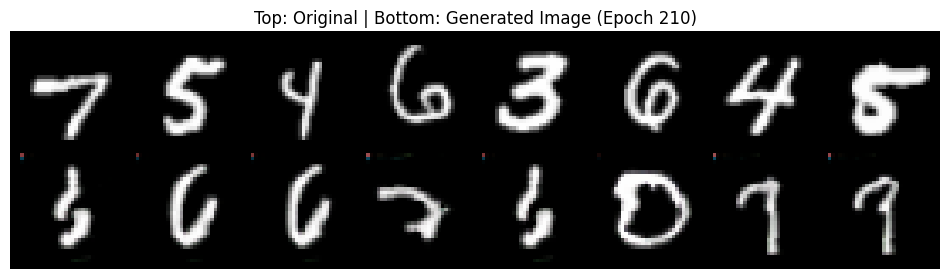

Epoch-211/1000: 100%|██████████| 469/469 [04:12<00:00,  1.86it/s, GenLoss=5.08, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.689227020816762
Discriminator Loss: 0.19139180133846015


Epoch-212/1000: 100%|██████████| 469/469 [04:02<00:00,  1.94it/s, GenLoss=4.14, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.391952620386315
Discriminator Loss: 0.1990775491700752


Epoch-213/1000: 100%|██████████| 469/469 [03:22<00:00,  2.32it/s, GenLoss=4.73, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.3296404784676366
Discriminator Loss: 0.20700849262254833


Epoch-214/1000: 100%|██████████| 469/469 [03:37<00:00,  2.15it/s, GenLoss=4.37, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.276285774926387
Discriminator Loss: 0.19959287135712883


Epoch-215/1000: 100%|██████████| 469/469 [04:24<00:00,  1.77it/s, GenLoss=3.61, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.53667936497914
Discriminator Loss: 0.20278185526572312


Epoch-216/1000: 100%|██████████| 469/469 [04:17<00:00,  1.82it/s, GenLoss=3.58, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.372467318577553
Discriminator Loss: 0.20423814072919044


Epoch-217/1000: 100%|██████████| 469/469 [04:13<00:00,  1.85it/s, GenLoss=5.42, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.419099473749905
Discriminator Loss: 0.20070728580199326


Epoch-218/1000: 100%|██████████| 469/469 [04:15<00:00,  1.84it/s, GenLoss=3.79, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.0736312073176855
Discriminator Loss: 0.21423312195582683


Epoch-219/1000: 100%|██████████| 469/469 [05:07<00:00,  1.53it/s, GenLoss=3.07, DisLoss=0.229, DisSteps=1]


Generator Loss: 4.310674811222914
Discriminator Loss: 0.20970119443783627


Epoch-220/1000: 100%|██████████| 469/469 [03:57<00:00,  1.98it/s, GenLoss=4.75, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.290363417505455
Discriminator Loss: 0.21127246682450715


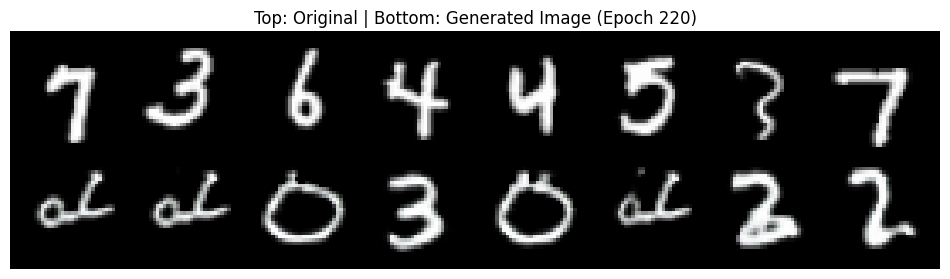

Epoch-221/1000: 100%|██████████| 469/469 [01:47<00:00,  4.38it/s, GenLoss=4.5, DisLoss=0.181, DisSteps=1] 


Generator Loss: 4.241148833526985
Discriminator Loss: 0.2026976680259969


Epoch-222/1000: 100%|██████████| 469/469 [01:46<00:00,  4.40it/s, GenLoss=4.22, DisLoss=0.208, DisSteps=1]


Generator Loss: 4.649379104439384
Discriminator Loss: 0.19081087975995117


Epoch-223/1000: 100%|██████████| 469/469 [01:40<00:00,  4.65it/s, GenLoss=4.9, DisLoss=0.185, DisSteps=1] 


Generator Loss: 4.359826141583132
Discriminator Loss: 0.21343021828736833


Epoch-224/1000: 100%|██████████| 469/469 [01:38<00:00,  4.76it/s, GenLoss=6.12, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.017499738156414
Discriminator Loss: 0.21428717031026445


Epoch-225/1000: 100%|██████████| 469/469 [01:45<00:00,  4.46it/s, GenLoss=6.11, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.2399558754109625
Discriminator Loss: 0.21535800200408456


Epoch-226/1000: 100%|██████████| 469/469 [01:53<00:00,  4.14it/s, GenLoss=3.81, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.0685691602194485
Discriminator Loss: 0.21570003305925234


Epoch-227/1000: 100%|██████████| 469/469 [01:39<00:00,  4.71it/s, GenLoss=3.76, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.014522160802569
Discriminator Loss: 0.20860572353100726


Epoch-228/1000: 100%|██████████| 469/469 [01:42<00:00,  4.56it/s, GenLoss=4.12, DisLoss=0.204, DisSteps=1]


Generator Loss: 4.290747877377183
Discriminator Loss: 0.21023590691181135


Epoch-229/1000: 100%|██████████| 469/469 [01:46<00:00,  4.42it/s, GenLoss=3.91, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.239011853996879
Discriminator Loss: 0.2098880730775882


Epoch-230/1000: 100%|██████████| 469/469 [01:49<00:00,  4.28it/s, GenLoss=5.78, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.210027568375886
Discriminator Loss: 0.20817915640914364


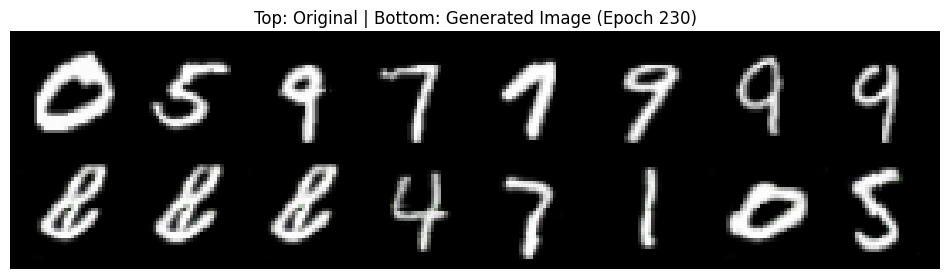

Epoch-231/1000: 100%|██████████| 469/469 [01:55<00:00,  4.08it/s, GenLoss=4.53, DisLoss=0.251, DisSteps=1]


Generator Loss: 4.533849272900807
Discriminator Loss: 0.20324774849008143


Epoch-232/1000: 100%|██████████| 469/469 [01:47<00:00,  4.36it/s, GenLoss=2.33, DisLoss=0.354, DisSteps=1]


Generator Loss: 4.500535983012429
Discriminator Loss: 0.20270097150858532


Epoch-233/1000: 100%|██████████| 469/469 [01:41<00:00,  4.64it/s, GenLoss=3.58, DisLoss=0.287, DisSteps=1]


Generator Loss: 3.9869410071545826
Discriminator Loss: 0.21132558635048776


Epoch-234/1000: 100%|██████████| 469/469 [01:41<00:00,  4.60it/s, GenLoss=2.53, DisLoss=0.413, DisSteps=1]


Generator Loss: 3.932992635251108
Discriminator Loss: 0.21399855111707758


Epoch-235/1000: 100%|██████████| 469/469 [01:23<00:00,  5.59it/s, GenLoss=2.45, DisLoss=0.22, DisSteps=1] 


Generator Loss: 3.676338365083056
Discriminator Loss: 0.24112914060987134


Epoch-236/1000: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s, GenLoss=4.02, DisLoss=0.205, DisSteps=1]


Generator Loss: 3.950132338477096
Discriminator Loss: 0.21097388406043877


Epoch-237/1000: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s, GenLoss=3.39, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.15835775495338
Discriminator Loss: 0.2006620245892356


Epoch-238/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s, GenLoss=4.07, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.189069329294314
Discriminator Loss: 0.21745655172542214


Epoch-239/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=4.09, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.190665461615459
Discriminator Loss: 0.2027917306052088


Epoch-240/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s, GenLoss=4.11, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.030997329429269
Discriminator Loss: 0.2064406071453969


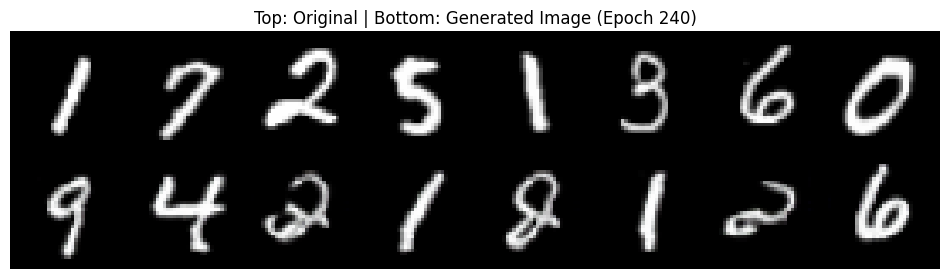

Epoch-241/1000: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s, GenLoss=4.87, DisLoss=0.202, DisSteps=1]


Generator Loss: 3.999405686026697
Discriminator Loss: 0.21176829873753


Epoch-242/1000: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s, GenLoss=4.37, DisLoss=0.206, DisSteps=1]


Generator Loss: 4.174402839339364
Discriminator Loss: 0.2075688891065146


Epoch-243/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=4.31, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.3137671896643734
Discriminator Loss: 0.2068450055651065


Epoch-244/1000: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s, GenLoss=2.39, DisLoss=0.353, DisSteps=1]


Generator Loss: 4.5123860337840975
Discriminator Loss: 0.2021849265357833


Epoch-245/1000: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s, GenLoss=5.47, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.266748813169597
Discriminator Loss: 0.2119506079632082


Epoch-246/1000: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s, GenLoss=5.17, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.246386891997445
Discriminator Loss: 0.20782040034148738


Epoch-247/1000: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s, GenLoss=2.88, DisLoss=0.231, DisSteps=1]


Generator Loss: 4.508735182442899
Discriminator Loss: 0.20413985753110223


Epoch-248/1000: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s, GenLoss=3.85, DisLoss=0.323, DisSteps=1]


Generator Loss: 4.225749639814088
Discriminator Loss: 0.20885544421194968


Epoch-249/1000: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s, GenLoss=3.67, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.221806486024023
Discriminator Loss: 0.21185139282298748


Epoch-250/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s, GenLoss=4.26, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.13859007302632
Discriminator Loss: 0.21544496432296248


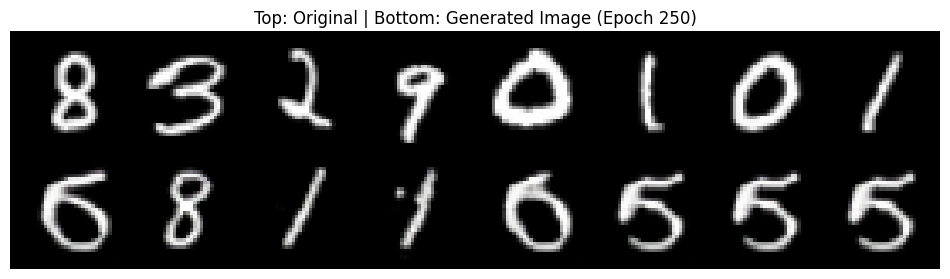

Epoch-251/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, GenLoss=4.64, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.443523462647314
Discriminator Loss: 0.20695296330238455


Epoch-252/1000: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s, GenLoss=2.57, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.117800242611086
Discriminator Loss: 0.20549667860145


Epoch-253/1000: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s, GenLoss=3.25, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.194340423226103
Discriminator Loss: 0.20910562069685473


Epoch-254/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=4.14, DisLoss=0.234, DisSteps=1]


Generator Loss: 4.26753553678232
Discriminator Loss: 0.20799489554438763


Epoch-255/1000: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s, GenLoss=4.95, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.314937983494578
Discriminator Loss: 0.20346606892944652


Epoch-256/1000: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s, GenLoss=6.37, DisLoss=0.204, DisSteps=1]


Generator Loss: 4.4177792667071705
Discriminator Loss: 0.20095138896757098


Epoch-257/1000: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s, GenLoss=4.54, DisLoss=0.226, DisSteps=1]


Generator Loss: 4.357149357480536
Discriminator Loss: 0.20479822794257452


Epoch-258/1000: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s, GenLoss=3.62, DisLoss=0.206, DisSteps=1]


Generator Loss: 4.329506777242811
Discriminator Loss: 0.20944852300925548


Epoch-259/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=5.17, DisLoss=0.217, DisSteps=1]


Generator Loss: 4.3344493669741695
Discriminator Loss: 0.20173645861494516


Epoch-260/1000: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, GenLoss=4.27, DisLoss=0.209, DisSteps=1]


Generator Loss: 4.238354812298756
Discriminator Loss: 0.22171516373340508


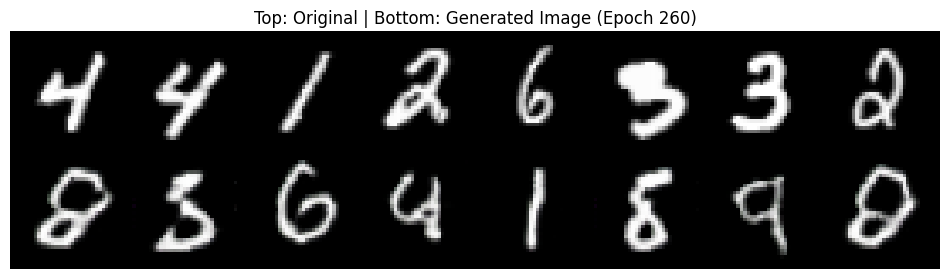

Epoch-261/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s, GenLoss=2.86, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.020006624620352
Discriminator Loss: 0.21283585160398788


Epoch-262/1000: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s, GenLoss=4.61, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.194588062351446
Discriminator Loss: 0.20738324669124222


Epoch-263/1000: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s, GenLoss=6.81, DisLoss=0.263, DisSteps=1]


Generator Loss: 4.41565656585734
Discriminator Loss: 0.20035472632979534


Epoch-264/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=7.56, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.528125586286028
Discriminator Loss: 0.21130263322451984


Epoch-265/1000: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s, GenLoss=4.99, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.349342718307398
Discriminator Loss: 0.20324421704196727


Epoch-266/1000: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s, GenLoss=2.8, DisLoss=0.203, DisSteps=1] 


Generator Loss: 4.324078372292427
Discriminator Loss: 0.20469247185980588


Epoch-267/1000: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s, GenLoss=4.92, DisLoss=0.2, DisSteps=1]  


Generator Loss: 4.3416010629393655
Discriminator Loss: 0.20042107894476544


Epoch-268/1000: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s, GenLoss=4.26, DisLoss=0.238, DisSteps=1]


Generator Loss: 4.710378225932497
Discriminator Loss: 0.19203540133133626


Epoch-269/1000: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s, GenLoss=3.96, DisLoss=0.237, DisSteps=1]


Generator Loss: 4.048426729275474
Discriminator Loss: 0.21132638303837034


Epoch-270/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=2.52, DisLoss=0.236, DisSteps=1]


Generator Loss: 4.103855948966704
Discriminator Loss: 0.20318271118059342


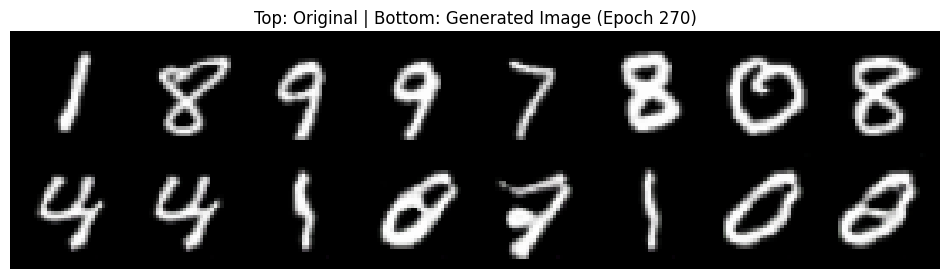

Epoch-271/1000: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s, GenLoss=3.69, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.194670240253782
Discriminator Loss: 0.21327449047743385


Epoch-272/1000: 100%|██████████| 469/469 [00:32<00:00, 14.23it/s, GenLoss=4.74, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.271047297062904
Discriminator Loss: 0.20298730183257732


Epoch-273/1000: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s, GenLoss=4.34, DisLoss=0.255, DisSteps=1]


Generator Loss: 4.266679075989388
Discriminator Loss: 0.21001562660436895


Epoch-274/1000: 100%|██████████| 469/469 [00:33<00:00, 14.19it/s, GenLoss=3.48, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.446540351615532
Discriminator Loss: 0.20507525428653017


Epoch-275/1000: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s, GenLoss=5.39, DisLoss=0.539, DisSteps=1]


Generator Loss: 4.314551535445744
Discriminator Loss: 0.20549023243537082


Epoch-276/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=5.99, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.3314990300867855
Discriminator Loss: 0.20974220262407495


Epoch-277/1000: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s, GenLoss=5.55, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.236976315471917
Discriminator Loss: 0.20433024950881504


Epoch-278/1000: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s, GenLoss=5.47, DisLoss=0.281, DisSteps=1]


Generator Loss: 4.1444289221692445
Discriminator Loss: 0.20818367968998483


Epoch-279/1000: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s, GenLoss=3.84, DisLoss=0.221, DisSteps=1]


Generator Loss: 4.094756713045686
Discriminator Loss: 0.20993947728610496


Epoch-280/1000: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s, GenLoss=4.26, DisLoss=0.194, DisSteps=1]


Generator Loss: 4.585541969169178
Discriminator Loss: 0.2016574591715961


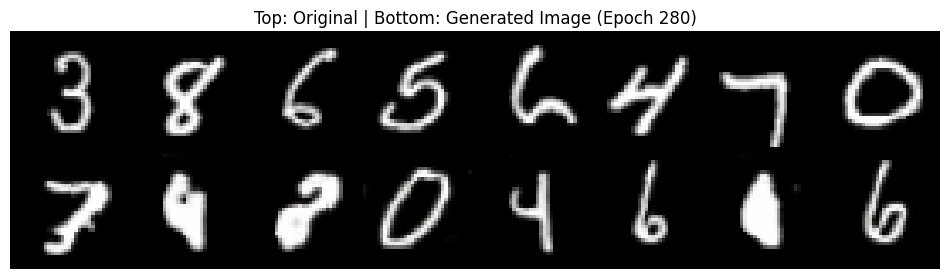

Epoch-281/1000: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s, GenLoss=5.16, DisLoss=0.236, DisSteps=1]


Generator Loss: 4.5289333072552544
Discriminator Loss: 0.201223386693865


Epoch-282/1000: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s, GenLoss=3.69, DisLoss=0.211, DisSteps=1]


Generator Loss: 4.584047727239158
Discriminator Loss: 0.19520110362120022


Epoch-283/1000: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s, GenLoss=4.89, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.315028924677672
Discriminator Loss: 0.201751080117246


Epoch-284/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=3.24, DisLoss=0.26, DisSteps=1] 


Generator Loss: 4.1482202073912635
Discriminator Loss: 0.21553245841313018


Epoch-285/1000: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s, GenLoss=4.17, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.102980013341029
Discriminator Loss: 0.21676228489321686


Epoch-286/1000: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s, GenLoss=5.59, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.511144676696517
Discriminator Loss: 0.201601102344517


Epoch-287/1000: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s, GenLoss=4.45, DisLoss=0.22, DisSteps=1] 


Generator Loss: 4.753445968953277
Discriminator Loss: 0.1974360433532231


Epoch-288/1000: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s, GenLoss=5.02, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.9055913084351435
Discriminator Loss: 0.1929149994654442


Epoch-289/1000: 100%|██████████| 469/469 [00:30<00:00, 15.13it/s, GenLoss=5.35, DisLoss=0.204, DisSteps=1]


Generator Loss: 4.70641554774506
Discriminator Loss: 0.20558739099294138


Epoch-290/1000: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s, GenLoss=3.47, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.381057198367902
Discriminator Loss: 0.2005387524615473


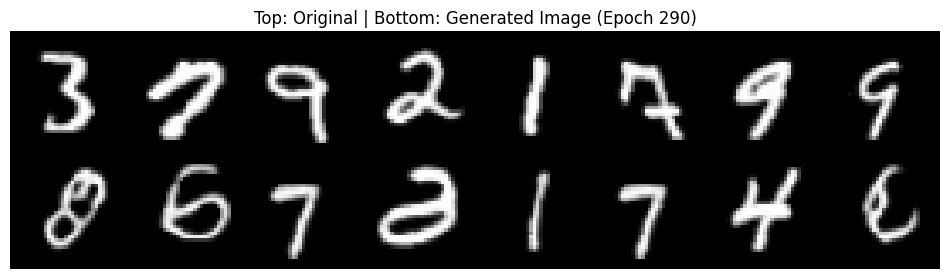

Epoch-291/1000: 100%|██████████| 469/469 [00:31<00:00, 15.04it/s, GenLoss=4, DisLoss=0.212, DisSteps=1]   


Generator Loss: 4.429614703538321
Discriminator Loss: 0.20483141362285817


Epoch-292/1000: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s, GenLoss=5.77, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.297438553401402
Discriminator Loss: 0.20077283175261035


Epoch-293/1000: 100%|██████████| 469/469 [00:31<00:00, 14.90it/s, GenLoss=4.59, DisLoss=0.237, DisSteps=1]


Generator Loss: 4.241998425933089
Discriminator Loss: 0.20582662510083938


Epoch-294/1000: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s, GenLoss=3.49, DisLoss=0.278, DisSteps=1]


Generator Loss: 4.498323428351234
Discriminator Loss: 0.20451631697256173


Epoch-295/1000: 100%|██████████| 469/469 [00:30<00:00, 15.54it/s, GenLoss=3.6, DisLoss=0.191, DisSteps=1] 


Generator Loss: 4.079836799900161
Discriminator Loss: 0.20841448390280515


Epoch-296/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=3.95, DisLoss=0.249, DisSteps=1]


Generator Loss: 4.121284948483205
Discriminator Loss: 0.2084371436442902


Epoch-297/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=5.56, DisLoss=0.204, DisSteps=1]


Generator Loss: 4.035707400551737
Discriminator Loss: 0.21800828177029136


Epoch-298/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s, GenLoss=4.18, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.095784592475972
Discriminator Loss: 0.21260906095062493


Epoch-299/1000: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s, GenLoss=4.68, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.285658253789711
Discriminator Loss: 0.20761654311532912


Epoch-300/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s, GenLoss=4.57, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.059140268673521
Discriminator Loss: 0.21594257331860345


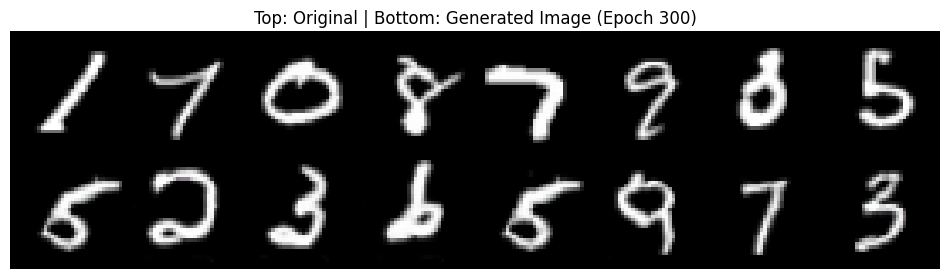

Epoch-301/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s, GenLoss=3.39, DisLoss=0.205, DisSteps=1]


Generator Loss: 4.031588444831783
Discriminator Loss: 0.2149826226585201


Epoch-302/1000: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s, GenLoss=4.79, DisLoss=0.223, DisSteps=1]


Generator Loss: 4.176868778047785
Discriminator Loss: 0.21143970071379817


Epoch-303/1000: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s, GenLoss=4.98, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.078329046143652
Discriminator Loss: 0.20853302689757683


Epoch-304/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=2.01, DisLoss=0.207, DisSteps=1]


Generator Loss: 4.102247675090457
Discriminator Loss: 0.221282422860294


Epoch-305/1000: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s, GenLoss=3.35, DisLoss=0.203, DisSteps=1]


Generator Loss: 3.9831810752466037
Discriminator Loss: 0.21584989425978426


Epoch-306/1000: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s, GenLoss=5.18, DisLoss=0.231, DisSteps=1]


Generator Loss: 4.532110283878058
Discriminator Loss: 0.1997728305203574


Epoch-307/1000: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s, GenLoss=3.47, DisLoss=0.225, DisSteps=1]


Generator Loss: 4.161416927634526
Discriminator Loss: 0.21228363229903077


Epoch-308/1000: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s, GenLoss=3.99, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.239691566048401
Discriminator Loss: 0.20563368191088693


Epoch-309/1000: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s, GenLoss=4.62, DisLoss=0.211, DisSteps=1]


Generator Loss: 4.291643748659569
Discriminator Loss: 0.21347855088680284


Epoch-310/1000: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s, GenLoss=4.65, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.420584258748524
Discriminator Loss: 0.20020828089480208


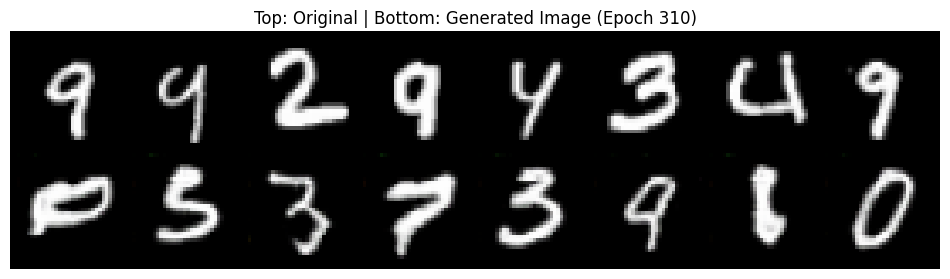

Epoch-311/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=3.63, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.330168084549243
Discriminator Loss: 0.2054334752468158


Epoch-312/1000: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s, GenLoss=3.98, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.428925548789343
Discriminator Loss: 0.20727677744970138


Epoch-313/1000: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, GenLoss=4.36, DisLoss=0.2, DisSteps=1]  


Generator Loss: 4.388195767839834
Discriminator Loss: 0.21020819891744585


Epoch-314/1000: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s, GenLoss=4.78, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.387380931168985
Discriminator Loss: 0.2054064064455439


Epoch-315/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=4.66, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.548276782798361
Discriminator Loss: 0.2010317901367826


Epoch-316/1000: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s, GenLoss=4.94, DisLoss=0.226, DisSteps=1]


Generator Loss: 4.579316718237741
Discriminator Loss: 0.1994374220622882


Epoch-317/1000: 100%|██████████| 469/469 [00:35<00:00, 13.38it/s, GenLoss=4.81, DisLoss=0.17, DisSteps=1] 


Generator Loss: 4.951163536449994
Discriminator Loss: 0.19644000903883976


Epoch-318/1000: 100%|██████████| 469/469 [00:38<00:00, 12.34it/s, GenLoss=4.62, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.40096810580825
Discriminator Loss: 0.20158937535306284


Epoch-319/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=6.27, DisLoss=0.247, DisSteps=1]


Generator Loss: 4.394129248824455
Discriminator Loss: 0.202352522691684


Epoch-320/1000: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s, GenLoss=3.3, DisLoss=0.359, DisSteps=1] 


Generator Loss: 4.238007160646321
Discriminator Loss: 0.20979035872894564


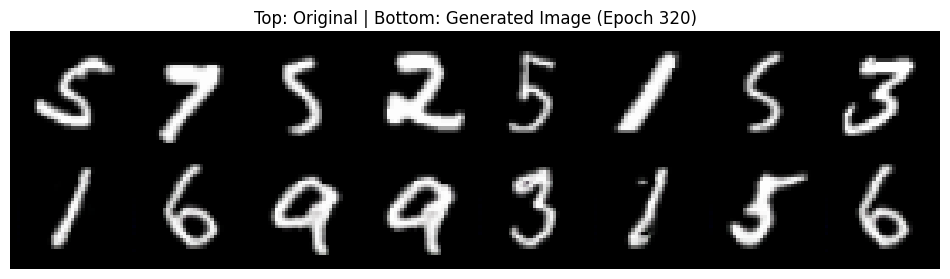

Epoch-321/1000: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s, GenLoss=4.27, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.096509095956522
Discriminator Loss: 0.2066788545358918


Epoch-322/1000: 100%|██████████| 469/469 [00:32<00:00, 14.24it/s, GenLoss=3.96, DisLoss=0.238, DisSteps=1]


Generator Loss: 4.325644020841065
Discriminator Loss: 0.20923527233254935


Epoch-323/1000: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s, GenLoss=3.04, DisLoss=0.244, DisSteps=1]


Generator Loss: 4.216067496647459
Discriminator Loss: 0.21716375855494663


Epoch-324/1000: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s, GenLoss=3.6, DisLoss=0.18, DisSteps=1]  


Generator Loss: 4.011938774763649
Discriminator Loss: 0.20857069296623343


Epoch-325/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=4.12, DisLoss=0.196, DisSteps=1]


Generator Loss: 4.103584089513018
Discriminator Loss: 0.2137547193813934


Epoch-326/1000: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s, GenLoss=3.94, DisLoss=0.201, DisSteps=1]


Generator Loss: 3.88352039983786
Discriminator Loss: 0.21482698130073832


Epoch-327/1000: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s, GenLoss=3.34, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.173688094499014
Discriminator Loss: 0.2036791816194937


Epoch-328/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=3.76, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.325851602340812
Discriminator Loss: 0.20440083459369154


Epoch-329/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=2.83, DisLoss=0.192, DisSteps=1]


Generator Loss: 3.9266339598942412
Discriminator Loss: 0.2153627479444943


Epoch-330/1000: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s, GenLoss=4.33, DisLoss=0.248, DisSteps=1]


Generator Loss: 4.056426624245227
Discriminator Loss: 0.2111786289382845


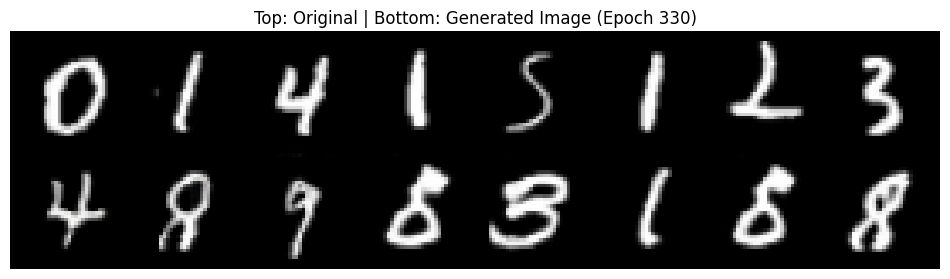

Epoch-331/1000: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s, GenLoss=4.2, DisLoss=0.201, DisSteps=1]  


Generator Loss: 3.913671924488377
Discriminator Loss: 0.22162140635793398


Epoch-332/1000: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s, GenLoss=3.99, DisLoss=0.192, DisSteps=1] 


Generator Loss: 4.019167335938289
Discriminator Loss: 0.22089524722811002


Epoch-333/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=2.61, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.467391688940622
Discriminator Loss: 0.20661485157033274


Epoch-334/1000: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s, GenLoss=3.94, DisLoss=0.222, DisSteps=1]


Generator Loss: 3.810656950672044
Discriminator Loss: 0.221685474392956


Epoch-335/1000: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s, GenLoss=4.4, DisLoss=0.202, DisSteps=1] 


Generator Loss: 4.077608475552947
Discriminator Loss: 0.21140037689890182


Epoch-336/1000: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s, GenLoss=5.17, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.34251391023461
Discriminator Loss: 0.1997725993140674


Epoch-337/1000: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s, GenLoss=4.45, DisLoss=0.198, DisSteps=1] 


Generator Loss: 4.399138163020616
Discriminator Loss: 0.2091995913590958


Epoch-338/1000: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s, GenLoss=4.88, DisLoss=0.232, DisSteps=1]


Generator Loss: 4.3266104075954415
Discriminator Loss: 0.2018191699089526


Epoch-339/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=3.98, DisLoss=0.187, DisSteps=1]


Generator Loss: 4.1083420789572225
Discriminator Loss: 0.21347208292499534


Epoch-340/1000: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s, GenLoss=3.84, DisLoss=0.239, DisSteps=1]


Generator Loss: 4.344843905109332
Discriminator Loss: 0.20807677459742216


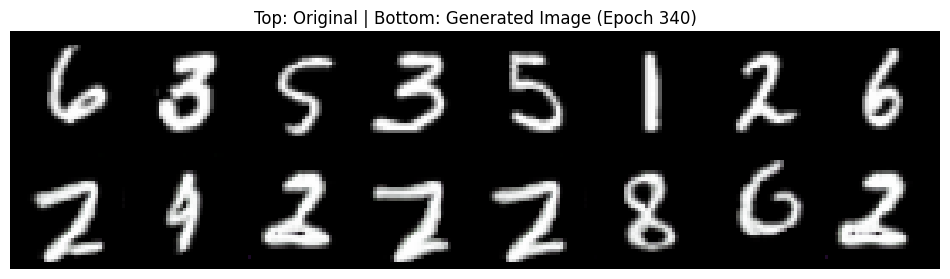

Epoch-341/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=4.85, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.313083617926153
Discriminator Loss: 0.2127852490080445


Epoch-342/1000: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s, GenLoss=5.1, DisLoss=0.192, DisSteps=1] 


Generator Loss: 4.223423308655143
Discriminator Loss: 0.2048425637900448


Epoch-343/1000: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s, GenLoss=4.27, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.288871727264258
Discriminator Loss: 0.20461727647003589


Epoch-344/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=5.04, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.242078199823782
Discriminator Loss: 0.2143650540093115


Epoch-345/1000: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s, GenLoss=4.26, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.087954002656916
Discriminator Loss: 0.21401724505271993


Epoch-346/1000: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s, GenLoss=4.39, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.424993521114911
Discriminator Loss: 0.2042372269289834


Epoch-347/1000: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s, GenLoss=3.75, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.1944346405041495
Discriminator Loss: 0.2170382373368562


Epoch-348/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=4.63, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.2841877548425185
Discriminator Loss: 0.21218144000847455


Epoch-349/1000: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s, GenLoss=3.65, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.160106307662118
Discriminator Loss: 0.20699750639990702


Epoch-350/1000: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s, GenLoss=4.01, DisLoss=0.225, DisSteps=1]


Generator Loss: 4.067211464524015
Discriminator Loss: 0.2121690666116377


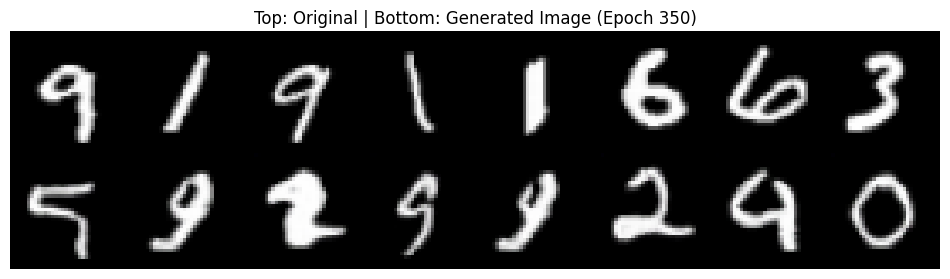

Epoch-351/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s, GenLoss=4.67, DisLoss=0.221, DisSteps=1]


Generator Loss: 4.176261434931236
Discriminator Loss: 0.21440158234730458


Epoch-352/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=4.32, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.0037241648000945
Discriminator Loss: 0.206733926463483


Epoch-353/1000: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s, GenLoss=5.44, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.090211006369926
Discriminator Loss: 0.2180120594529455


Epoch-354/1000: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s, GenLoss=3.91, DisLoss=0.23, DisSteps=1] 


Generator Loss: 4.077764277010838
Discriminator Loss: 0.2117942169086257


Epoch-355/1000: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s, GenLoss=4.15, DisLoss=0.255, DisSteps=1]


Generator Loss: 4.143357096196238
Discriminator Loss: 0.21366216776086322


Epoch-356/1000: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, GenLoss=4.85, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.0459008392240445
Discriminator Loss: 0.21860126823758774


Epoch-357/1000: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, GenLoss=4.33, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.266966942530959
Discriminator Loss: 0.2165604140013774


Epoch-358/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s, GenLoss=2.87, DisLoss=0.193, DisSteps=1]


Generator Loss: 3.800803812073746
Discriminator Loss: 0.21257231614864203


Epoch-359/1000: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s, GenLoss=4.96, DisLoss=0.195, DisSteps=1]


Generator Loss: 3.9345937957133312
Discriminator Loss: 0.2197009178239908


Epoch-360/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=2.51, DisLoss=0.229, DisSteps=1]


Generator Loss: 3.9748739481989
Discriminator Loss: 0.21271701763942044


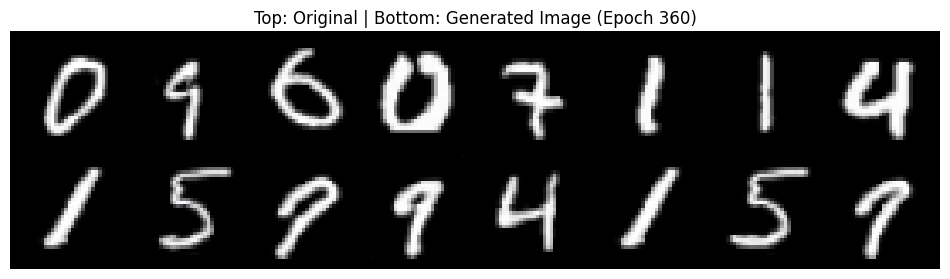

Epoch-361/1000: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s, GenLoss=2.25, DisLoss=0.294, DisSteps=1]


Generator Loss: 4.074026741452817
Discriminator Loss: 0.21611775905847042


Epoch-362/1000: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s, GenLoss=3.12, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.171466859673132
Discriminator Loss: 0.21860506927280793


Epoch-363/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=4.49, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.187355508428139
Discriminator Loss: 0.21400288252561078


Epoch-364/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=3.45, DisLoss=0.197, DisSteps=1]


Generator Loss: 3.887057458159766
Discriminator Loss: 0.21144897648012206


Epoch-365/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=5.35, DisLoss=0.24, DisSteps=1] 


Generator Loss: 3.89809291220423
Discriminator Loss: 0.21769223284365527


Epoch-366/1000: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s, GenLoss=2.97, DisLoss=0.23, DisSteps=1] 


Generator Loss: 4.189694978789226
Discriminator Loss: 0.21553128579659248


Epoch-367/1000: 100%|██████████| 469/469 [00:31<00:00, 15.02it/s, GenLoss=3.71, DisLoss=0.304, DisSteps=1]


Generator Loss: 4.183006848861922
Discriminator Loss: 0.20768528868521707


Epoch-368/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=3.89, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.063505524511276
Discriminator Loss: 0.21149379977666494


Epoch-369/1000: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s, GenLoss=4.68, DisLoss=0.22, DisSteps=1] 


Generator Loss: 4.243471664914699
Discriminator Loss: 0.21073871857321846


Epoch-370/1000: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s, GenLoss=4.62, DisLoss=0.215, DisSteps=1]


Generator Loss: 4.138228385687383
Discriminator Loss: 0.21045556079858402


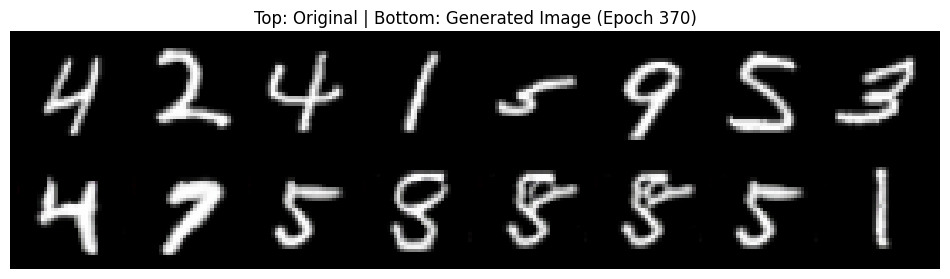

Epoch-371/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=4.82, DisLoss=0.194, DisSteps=1]


Generator Loss: 4.227342315574191
Discriminator Loss: 0.20982916783422295


Epoch-372/1000: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s, GenLoss=3.29, DisLoss=0.245, DisSteps=1]


Generator Loss: 4.393764524063322
Discriminator Loss: 0.206415155834989


Epoch-373/1000: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s, GenLoss=3.19, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.398564393586441
Discriminator Loss: 0.20950074122150317


Epoch-374/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=4.97, DisLoss=0.237, DisSteps=1]


Generator Loss: 4.283698566178523
Discriminator Loss: 0.20807831294373916


Epoch-375/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=4.54, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.076094108095555
Discriminator Loss: 0.218106166259058


Epoch-376/1000: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s, GenLoss=3.86, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.522817236019859
Discriminator Loss: 0.21304811346632585


Epoch-377/1000: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s, GenLoss=4.06, DisLoss=0.207, DisSteps=1]


Generator Loss: 4.073475346636417
Discriminator Loss: 0.21165505019840655


Epoch-378/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=3.96, DisLoss=0.206, DisSteps=1]


Generator Loss: 3.9228697161176314
Discriminator Loss: 0.21304910469538113


Epoch-379/1000: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s, GenLoss=4.81, DisLoss=0.227, DisSteps=1]


Generator Loss: 4.404496854048039
Discriminator Loss: 0.21066830823543484


Epoch-380/1000: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s, GenLoss=6.52, DisLoss=0.325, DisSteps=1]


Generator Loss: 4.269202087733792
Discriminator Loss: 0.21442967383210848


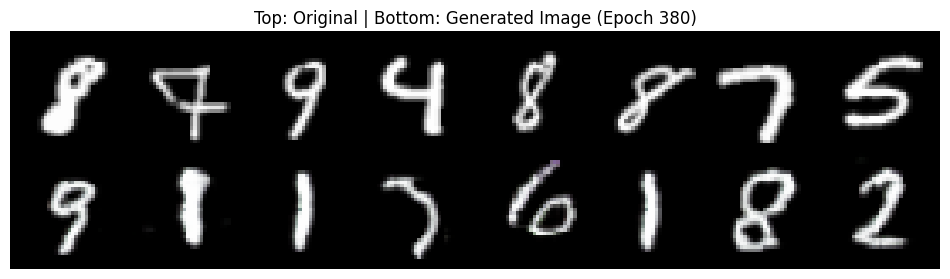

Epoch-381/1000: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s, GenLoss=4.03, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.023568187441144
Discriminator Loss: 0.2158513679496769


Epoch-382/1000: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s, GenLoss=5.47, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.003027374047969
Discriminator Loss: 0.2132909941965583


Epoch-383/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=2.72, DisLoss=0.258, DisSteps=1]


Generator Loss: 3.9370810520420196
Discriminator Loss: 0.21809114239363273


Epoch-384/1000: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s, GenLoss=3.35, DisLoss=0.219, DisSteps=1]


Generator Loss: 3.990075126385638
Discriminator Loss: 0.22138050611593577


Epoch-385/1000: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s, GenLoss=3.29, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.382240883577099
Discriminator Loss: 0.20883099626757698


Epoch-386/1000: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s, GenLoss=4, DisLoss=0.186, DisSteps=1]   


Generator Loss: 4.092231671693228
Discriminator Loss: 0.20999386074192233


Epoch-387/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=4.24, DisLoss=0.189, DisSteps=1]


Generator Loss: 3.828391030653199
Discriminator Loss: 0.21609116366295927


Epoch-388/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=4.7, DisLoss=0.197, DisSteps=1] 


Generator Loss: 3.863572670706808
Discriminator Loss: 0.2155479356360588


Epoch-389/1000: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s, GenLoss=2.76, DisLoss=0.222, DisSteps=1] 


Generator Loss: 3.9467048901738897
Discriminator Loss: 0.22434403307275222


Epoch-390/1000: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s, GenLoss=5.99, DisLoss=0.275, DisSteps=1]


Generator Loss: 4.214695358073025
Discriminator Loss: 0.211119449755022


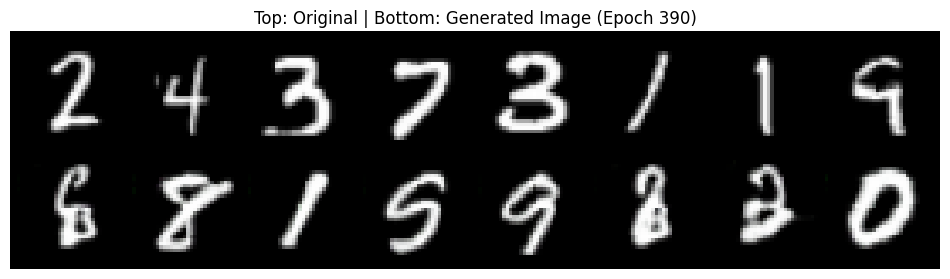

Epoch-391/1000: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s, GenLoss=6.84, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.17522390336116
Discriminator Loss: 0.20955570506007432


Epoch-392/1000: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s, GenLoss=5.9, DisLoss=0.187, DisSteps=1] 


Generator Loss: 4.155409189683796
Discriminator Loss: 0.20759545752742906


Epoch-393/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=4.95, DisLoss=0.244, DisSteps=1]


Generator Loss: 4.188650963657192
Discriminator Loss: 0.21313242700054194


Epoch-394/1000: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s, GenLoss=5.01, DisLoss=0.216, DisSteps=1]


Generator Loss: 4.681504910434487
Discriminator Loss: 0.20264373313008086


Epoch-395/1000: 100%|██████████| 469/469 [00:33<00:00, 14.16it/s, GenLoss=5.91, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.603659686757557
Discriminator Loss: 0.1965739372124804


Epoch-396/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=2.64, DisLoss=0.221, DisSteps=1]


Generator Loss: 4.7334727885118175
Discriminator Loss: 0.1914049107382801


Epoch-397/1000: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s, GenLoss=5.35, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.8816778212468
Discriminator Loss: 0.19664968794851162


Epoch-398/1000: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s, GenLoss=4.72, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.3870431642288334
Discriminator Loss: 0.20821063763805545


Epoch-399/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=3.71, DisLoss=0.255, DisSteps=1]


Generator Loss: 4.615162991257365
Discriminator Loss: 0.20097558858043857


Epoch-400/1000: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s, GenLoss=3.75, DisLoss=0.232, DisSteps=1]


Generator Loss: 4.362728811276239
Discriminator Loss: 0.21052269920357256


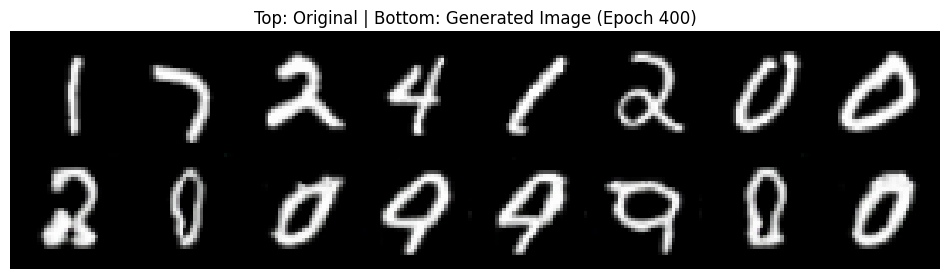

Epoch-401/1000: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s, GenLoss=4.21, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.490650203436423
Discriminator Loss: 0.20108118345107096


Epoch-402/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=3.74, DisLoss=0.238, DisSteps=1]


Generator Loss: 4.705714705147977
Discriminator Loss: 0.19656161045723125


Epoch-403/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=4.51, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.643192787414421
Discriminator Loss: 0.20040558570864866


Epoch-404/1000: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s, GenLoss=4.46, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.5437133474899
Discriminator Loss: 0.20436978661048133


Epoch-405/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=4.09, DisLoss=0.271, DisSteps=1]


Generator Loss: 4.343860438383464
Discriminator Loss: 0.20100072893633772


Epoch-406/1000: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s, GenLoss=3.9, DisLoss=0.178, DisSteps=1]  


Generator Loss: 4.108839643281152
Discriminator Loss: 0.21808625265225165


Epoch-407/1000: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s, GenLoss=4.86, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.240624472784844
Discriminator Loss: 0.20898448277129802


Epoch-408/1000: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s, GenLoss=3.21, DisLoss=0.246, DisSteps=1]


Generator Loss: 4.314854356525803
Discriminator Loss: 0.2051431009573723


Epoch-409/1000: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s, GenLoss=4.58, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.386900453170988
Discriminator Loss: 0.20678819312469793


Epoch-410/1000: 100%|██████████| 469/469 [00:31<00:00, 14.97it/s, GenLoss=4.91, DisLoss=0.24, DisSteps=1] 


Generator Loss: 4.192500519599996
Discriminator Loss: 0.2048213754508541


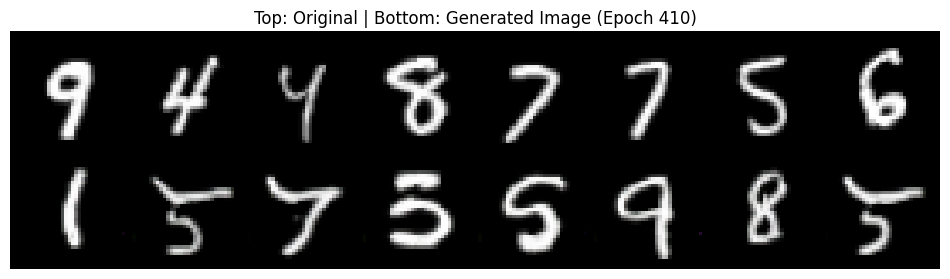

Epoch-411/1000: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s, GenLoss=3.03, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.11176110457764
Discriminator Loss: 0.21134788922663691


Epoch-412/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=4.81, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.246460457854687
Discriminator Loss: 0.2148543676333641


Epoch-413/1000: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s, GenLoss=4.03, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.309533131402184
Discriminator Loss: 0.2088244568818668


Epoch-414/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=4.95, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.442029704163069
Discriminator Loss: 0.20567070367112597


Epoch-415/1000: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s, GenLoss=5.1, DisLoss=0.226, DisSteps=1] 


Generator Loss: 5.038481678789867
Discriminator Loss: 0.197126444564191


Epoch-416/1000: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s, GenLoss=4.87, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.988385738340268
Discriminator Loss: 0.19318837098983813


Epoch-417/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=4.39, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.687479095926671
Discriminator Loss: 0.19592979073778652


Epoch-418/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=5.44, DisLoss=0.211, DisSteps=1]


Generator Loss: 4.469476673140455
Discriminator Loss: 0.2058615053195689


Epoch-419/1000: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s, GenLoss=6.28, DisLoss=0.402, DisSteps=1]


Generator Loss: 4.41007122632537
Discriminator Loss: 0.2002578566768276


Epoch-420/1000: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s, GenLoss=3.96, DisLoss=0.236, DisSteps=1]


Generator Loss: 4.1691621336093085
Discriminator Loss: 0.20948922700846373


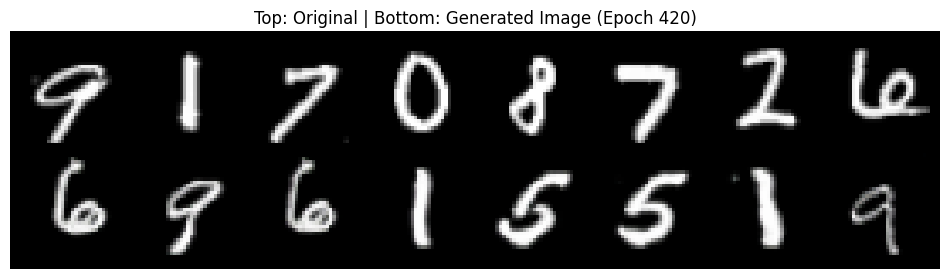

Epoch-421/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=3.55, DisLoss=0.227, DisSteps=1]


Generator Loss: 4.321376812229278
Discriminator Loss: 0.2030152998435726


Epoch-422/1000: 100%|██████████| 469/469 [00:33<00:00, 13.95it/s, GenLoss=3, DisLoss=0.178, DisSteps=1]   


Generator Loss: 4.889663736194944
Discriminator Loss: 0.20112449191272386


Epoch-423/1000: 100%|██████████| 469/469 [00:32<00:00, 14.30it/s, GenLoss=4.21, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.792917138223709
Discriminator Loss: 0.1998088720129497


Epoch-424/1000: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s, GenLoss=6.05, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.578251834363063
Discriminator Loss: 0.20423757496164807


Epoch-425/1000: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s, GenLoss=3.93, DisLoss=0.261, DisSteps=1]


Generator Loss: 5.025251992984113
Discriminator Loss: 0.1871347330145236


Epoch-426/1000: 100%|██████████| 469/469 [00:36<00:00, 13.03it/s, GenLoss=4.82, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.699847230524905
Discriminator Loss: 0.19241089489795507


Epoch-427/1000: 100%|██████████| 469/469 [00:37<00:00, 12.64it/s, GenLoss=5.24, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.554100419920899
Discriminator Loss: 0.19488993414175282


Epoch-428/1000: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s, GenLoss=5.5, DisLoss=0.192, DisSteps=1] 


Generator Loss: 4.4297300300110125
Discriminator Loss: 0.21300279007537531


Epoch-429/1000: 100%|██████████| 469/469 [00:45<00:00, 10.33it/s, GenLoss=4.15, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.3005831434782635
Discriminator Loss: 0.20195167421150817


Epoch-430/1000: 100%|██████████| 469/469 [00:44<00:00, 10.52it/s, GenLoss=2.44, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.241338056796141
Discriminator Loss: 0.20488384807669024


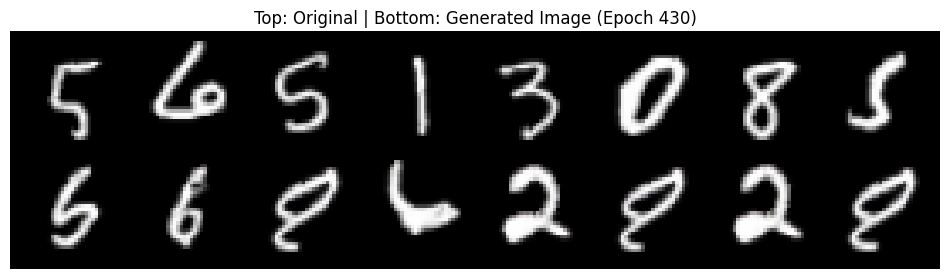

Epoch-431/1000: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s, GenLoss=4.08, DisLoss=0.324, DisSteps=1]


Generator Loss: 4.348081032858729
Discriminator Loss: 0.2092485830410203


Epoch-432/1000: 100%|██████████| 469/469 [00:40<00:00, 11.55it/s, GenLoss=5.38, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.495055156475954
Discriminator Loss: 0.20175568714960299


Epoch-433/1000: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s, GenLoss=3.5, DisLoss=0.197, DisSteps=1] 


Generator Loss: 4.023336188371248
Discriminator Loss: 0.20704244773016808


Epoch-434/1000: 100%|██████████| 469/469 [00:39<00:00, 11.87it/s, GenLoss=4.63, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.049091442561607
Discriminator Loss: 0.211313318183173


Epoch-435/1000: 100%|██████████| 469/469 [00:37<00:00, 12.66it/s, GenLoss=4.86, DisLoss=0.222, DisSteps=1]


Generator Loss: 4.133651567674649
Discriminator Loss: 0.20573890599996042


Epoch-436/1000: 100%|██████████| 469/469 [00:52<00:00,  9.00it/s, GenLoss=4.29, DisLoss=0.205, DisSteps=1]


Generator Loss: 4.083066541757157
Discriminator Loss: 0.21182936271116423


Epoch-437/1000: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s, GenLoss=4.87, DisLoss=0.236, DisSteps=1]


Generator Loss: 3.9136192918077968
Discriminator Loss: 0.20918427398209888


Epoch-438/1000: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s, GenLoss=4.25, DisLoss=0.207, DisSteps=1]


Generator Loss: 4.358665002942848
Discriminator Loss: 0.20609847613489196


Epoch-439/1000: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s, GenLoss=4.56, DisLoss=0.25, DisSteps=1] 


Generator Loss: 3.9915091241600673
Discriminator Loss: 0.21833083742081738


Epoch-440/1000: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s, GenLoss=5.07, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.263060828770147
Discriminator Loss: 0.2088961114824962


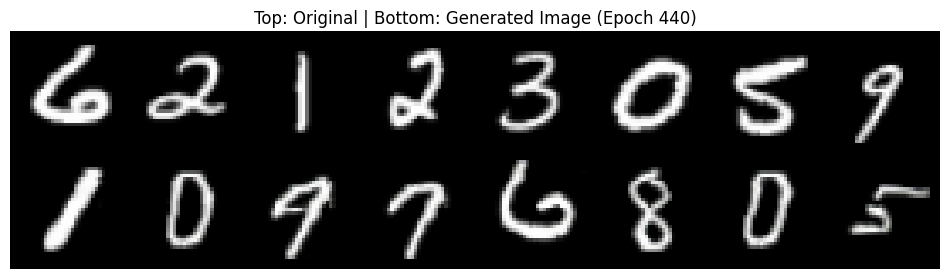

Epoch-441/1000: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s, GenLoss=4.6, DisLoss=0.372, DisSteps=1] 


Generator Loss: 4.356675194016398
Discriminator Loss: 0.2026703561991771


Epoch-442/1000: 100%|██████████| 469/469 [00:36<00:00, 12.71it/s, GenLoss=2.78, DisLoss=0.232, DisSteps=1]


Generator Loss: 4.143843635313038
Discriminator Loss: 0.21547313803421664


Epoch-443/1000: 100%|██████████| 469/469 [00:36<00:00, 12.70it/s, GenLoss=2.92, DisLoss=0.196, DisSteps=1]


Generator Loss: 3.911121735948998
Discriminator Loss: 0.2186100332340452


Epoch-444/1000: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s, GenLoss=1.59, DisLoss=0.209, DisSteps=1]


Generator Loss: 4.065981433335652
Discriminator Loss: 0.2114893289517238


Epoch-445/1000: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s, GenLoss=5.06, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.2589477201514665
Discriminator Loss: 0.20152463444641658


Epoch-446/1000: 100%|██████████| 469/469 [00:36<00:00, 12.68it/s, GenLoss=3.72, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.288424596603491
Discriminator Loss: 0.2041961192322184


Epoch-447/1000: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s, GenLoss=5.65, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.230945669257564
Discriminator Loss: 0.21450895080561322


Epoch-448/1000: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s, GenLoss=5.71, DisLoss=0.257, DisSteps=1]


Generator Loss: 4.303804158401896
Discriminator Loss: 0.20703811451061957


Epoch-449/1000: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s, GenLoss=5.33, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.43027482485212
Discriminator Loss: 0.20259701567036764


Epoch-450/1000: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s, GenLoss=5.58, DisLoss=0.291, DisSteps=1]


Generator Loss: 4.581161855126241
Discriminator Loss: 0.2030214454764242


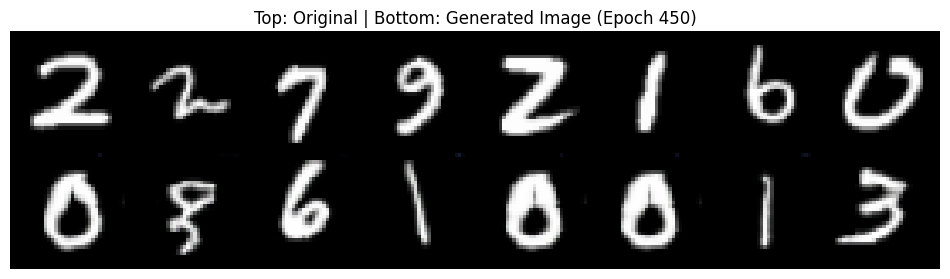

Epoch-451/1000: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s, GenLoss=6.01, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.677420096610909
Discriminator Loss: 0.1964482804859625


Epoch-452/1000: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s, GenLoss=4.67, DisLoss=0.211, DisSteps=1]


Generator Loss: 4.917905249829485
Discriminator Loss: 0.19935537394938438


Epoch-453/1000: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s, GenLoss=5.48, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.409898722858063
Discriminator Loss: 0.21393139762029464


Epoch-454/1000: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s, GenLoss=2.01, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.294112085025193
Discriminator Loss: 0.20557807735415665


Epoch-455/1000: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s, GenLoss=5.86, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.317356473601449
Discriminator Loss: 0.203036721899057


Epoch-456/1000: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s, GenLoss=4.25, DisLoss=0.196, DisSteps=1]


Generator Loss: 4.484567942904003
Discriminator Loss: 0.20054423342000194


Epoch-457/1000: 100%|██████████| 469/469 [00:39<00:00, 11.73it/s, GenLoss=4.06, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.488408785639033
Discriminator Loss: 0.20222496131717016


Epoch-458/1000: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s, GenLoss=5.2, DisLoss=0.186, DisSteps=1] 


Generator Loss: 4.80076979879123
Discriminator Loss: 0.19670921811925324


Epoch-459/1000: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s, GenLoss=5.76, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.6030142195443355
Discriminator Loss: 0.20538474485945346


Epoch-460/1000: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s, GenLoss=3.93, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.497976484583385
Discriminator Loss: 0.20818467098258453


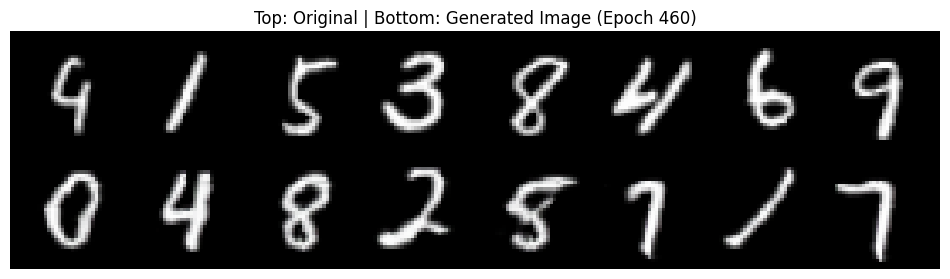

Epoch-461/1000: 100%|██████████| 469/469 [00:36<00:00, 12.96it/s, GenLoss=4.64, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.464543875854915
Discriminator Loss: 0.20588235375977781


Epoch-462/1000: 100%|██████████| 469/469 [00:36<00:00, 12.68it/s, GenLoss=3.24, DisLoss=0.31, DisSteps=1] 


Generator Loss: 4.33132934417806
Discriminator Loss: 0.19957958781388777


Epoch-463/1000: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s, GenLoss=5.33, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.876306805275142
Discriminator Loss: 0.19674191117159592


Epoch-464/1000: 100%|██████████| 469/469 [00:38<00:00, 12.27it/s, GenLoss=6.12, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.5765931062352685
Discriminator Loss: 0.20732095627896568


Epoch-465/1000: 100%|██████████| 469/469 [01:38<00:00,  4.74it/s, GenLoss=3.52, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.4669695365657685
Discriminator Loss: 0.19985397172762132


Epoch-466/1000: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s, GenLoss=2.72, DisLoss=0.246, DisSteps=1]


Generator Loss: 4.349668359959812
Discriminator Loss: 0.20308868952397344


Epoch-467/1000: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s, GenLoss=3.9, DisLoss=0.188, DisSteps=1] 


Generator Loss: 4.453875476617549
Discriminator Loss: 0.1995228515314395


Epoch-468/1000: 100%|██████████| 469/469 [01:01<00:00,  7.57it/s, GenLoss=5.32, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.583058631242211
Discriminator Loss: 0.1956145165444437


Epoch-469/1000: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s, GenLoss=4.21, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.469107540685739
Discriminator Loss: 0.2021410063322165


Epoch-470/1000: 100%|██████████| 469/469 [01:27<00:00,  5.36it/s, GenLoss=3.63, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.240017185079009
Discriminator Loss: 0.20656074586707646


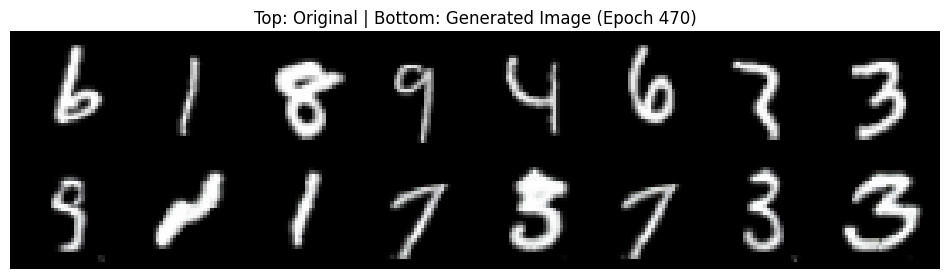

Epoch-471/1000: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s, GenLoss=2.54, DisLoss=0.235, DisSteps=1]


Generator Loss: 4.636625798017994
Discriminator Loss: 0.20099593438446395


Epoch-472/1000: 100%|██████████| 469/469 [01:58<00:00,  3.95it/s, GenLoss=4.43, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.087577208272938
Discriminator Loss: 0.20899950978217094


Epoch-473/1000: 100%|██████████| 469/469 [02:01<00:00,  3.87it/s, GenLoss=3.52, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.408214688809442
Discriminator Loss: 0.20517440111652366


Epoch-474/1000: 100%|██████████| 469/469 [03:07<00:00,  2.50it/s, GenLoss=3.73, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.295108858202058
Discriminator Loss: 0.20555676071882756


Epoch-475/1000: 100%|██████████| 469/469 [03:21<00:00,  2.33it/s, GenLoss=6.4, DisLoss=0.182, DisSteps=1] 


Generator Loss: 4.344367292898296
Discriminator Loss: 0.20297359644985402


Epoch-476/1000: 100%|██████████| 469/469 [03:07<00:00,  2.50it/s, GenLoss=3.53, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.161216064302652
Discriminator Loss: 0.20820863297117798


Epoch-477/1000: 100%|██████████| 469/469 [05:19<00:00,  1.47it/s, GenLoss=5.07, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.631591134234024
Discriminator Loss: 0.2018093002249183


Epoch-478/1000: 100%|██████████| 469/469 [03:07<00:00,  2.50it/s, GenLoss=4.68, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.570391093998321
Discriminator Loss: 0.19919936142877728


Epoch-479/1000: 100%|██████████| 469/469 [04:12<00:00,  1.86it/s, GenLoss=2.81, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.335759825035453
Discriminator Loss: 0.20790388420827863


Epoch-480/1000: 100%|██████████| 469/469 [12:34<00:00,  1.61s/it, GenLoss=5.36, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.417278581844973
Discriminator Loss: 0.20646374887113633


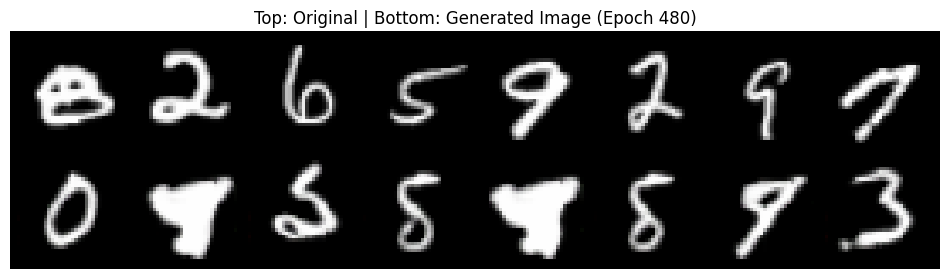

Epoch-481/1000: 100%|██████████| 469/469 [14:41<00:00,  1.88s/it, GenLoss=4.39, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.587628817507453
Discriminator Loss: 0.2006511291715382


Epoch-482/1000: 100%|██████████| 469/469 [04:49<00:00,  1.62it/s, GenLoss=4.03, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.2365578613809936
Discriminator Loss: 0.2074965557564042


Epoch-483/1000: 100%|██████████| 469/469 [01:36<00:00,  4.87it/s, GenLoss=4.86, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.229467335540349
Discriminator Loss: 0.20677655137805287


Epoch-484/1000: 100%|██████████| 469/469 [01:54<00:00,  4.11it/s, GenLoss=4.1, DisLoss=0.181, DisSteps=1] 


Generator Loss: 4.056556743345281
Discriminator Loss: 0.21483333736086196


Epoch-485/1000: 100%|██████████| 469/469 [01:34<00:00,  4.97it/s, GenLoss=4.08, DisLoss=0.275, DisSteps=1]


Generator Loss: 4.027115960365165
Discriminator Loss: 0.21022412952965003


Epoch-486/1000: 100%|██████████| 469/469 [01:37<00:00,  4.83it/s, GenLoss=4.24, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.092746568641174
Discriminator Loss: 0.2194347181744667


Epoch-487/1000: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, GenLoss=3.2, DisLoss=0.193, DisSteps=1] 


Generator Loss: 4.093997100523032
Discriminator Loss: 0.21261220185487256


Epoch-488/1000: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s, GenLoss=3.07, DisLoss=0.2, DisSteps=1]  


Generator Loss: 3.959738603787127
Discriminator Loss: 0.21268384454092745


Epoch-489/1000: 100%|██████████| 469/469 [00:35<00:00, 13.06it/s, GenLoss=4.2, DisLoss=0.228, DisSteps=1] 


Generator Loss: 4.301856127120793
Discriminator Loss: 0.20848755045994513


Epoch-490/1000: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s, GenLoss=4.24, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.311048123373914
Discriminator Loss: 0.20436694182312565


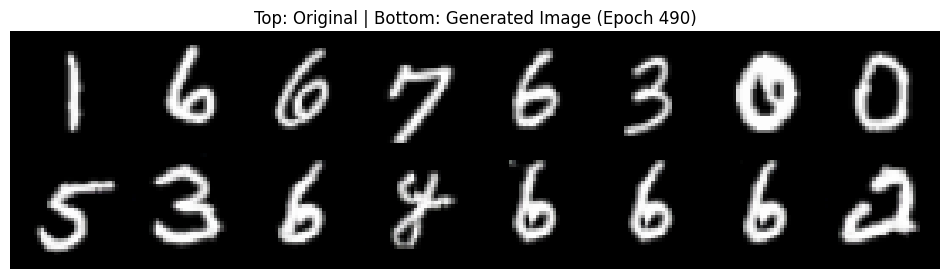

Epoch-491/1000: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s, GenLoss=4.54, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.179536585614625
Discriminator Loss: 0.20559282874120577


Epoch-492/1000: 100%|██████████| 469/469 [00:35<00:00, 13.25it/s, GenLoss=4.2, DisLoss=0.389, DisSteps=1] 


Generator Loss: 4.219638713387284
Discriminator Loss: 0.2118908728617849


Epoch-493/1000: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s, GenLoss=4.47, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.462840854486169
Discriminator Loss: 0.20223096038486912


Epoch-494/1000: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s, GenLoss=4.3, DisLoss=0.197, DisSteps=1] 


Generator Loss: 4.373285493871042
Discriminator Loss: 0.20115692401999857


Epoch-495/1000: 100%|██████████| 469/469 [00:35<00:00, 13.20it/s, GenLoss=2.88, DisLoss=0.313, DisSteps=1]


Generator Loss: 4.234096234287026
Discriminator Loss: 0.20412814950765068


Epoch-496/1000: 100%|██████████| 469/469 [00:35<00:00, 13.29it/s, GenLoss=5.37, DisLoss=0.415, DisSteps=1]


Generator Loss: 4.277876893848752
Discriminator Loss: 0.209021692400548


Epoch-497/1000: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s, GenLoss=3.83, DisLoss=0.214, DisSteps=1]


Generator Loss: 4.239684666143551
Discriminator Loss: 0.21206309006158222


Epoch-498/1000: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s, GenLoss=4.6, DisLoss=0.178, DisSteps=1] 


Generator Loss: 4.495928722658137
Discriminator Loss: 0.19658288686895675


Epoch-499/1000: 100%|██████████| 469/469 [00:35<00:00, 13.39it/s, GenLoss=3.15, DisLoss=0.215, DisSteps=1]


Generator Loss: 4.516239041712747
Discriminator Loss: 0.20020853675631825


Epoch-500/1000: 100%|██████████| 469/469 [00:35<00:00, 13.31it/s, GenLoss=6.4, DisLoss=0.182, DisSteps=1] 


Generator Loss: 4.613927310463716
Discriminator Loss: 0.2038693050268108


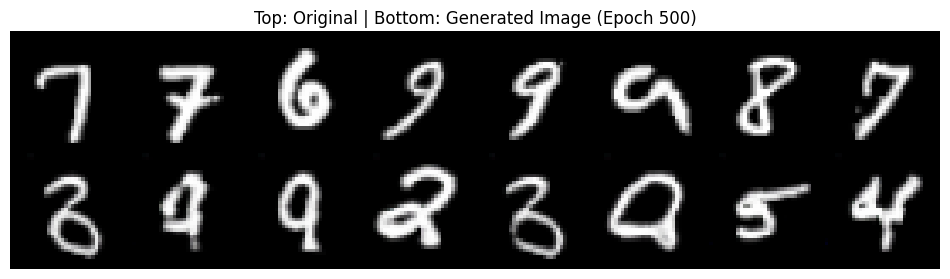

Epoch-501/1000: 100%|██████████| 469/469 [00:35<00:00, 13.21it/s, GenLoss=5.13, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.24069523633416
Discriminator Loss: 0.2047368483121461


Epoch-502/1000: 100%|██████████| 469/469 [00:35<00:00, 13.29it/s, GenLoss=4.25, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.457763649761549
Discriminator Loss: 0.20555015089415285


Epoch-503/1000: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s, GenLoss=3.92, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.3427686866666715
Discriminator Loss: 0.20742980811768758


Epoch-504/1000: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s, GenLoss=5.72, DisLoss=0.219, DisSteps=1]


Generator Loss: 3.8453112167081853
Discriminator Loss: 0.22003283064121376


Epoch-505/1000: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s, GenLoss=4.47, DisLoss=0.263, DisSteps=1]


Generator Loss: 4.028502372282146
Discriminator Loss: 0.2190940882732619


Epoch-506/1000: 100%|██████████| 469/469 [00:35<00:00, 13.25it/s, GenLoss=4.03, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.0061080399860955
Discriminator Loss: 0.2189515940288999


Epoch-507/1000: 100%|██████████| 469/469 [00:35<00:00, 13.38it/s, GenLoss=5.65, DisLoss=0.225, DisSteps=1]


Generator Loss: 4.235161463080693
Discriminator Loss: 0.20874506022248948


Epoch-508/1000: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s, GenLoss=5.23, DisLoss=0.221, DisSteps=1]


Generator Loss: 4.1764118511285355
Discriminator Loss: 0.20206518601507012


Epoch-509/1000: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s, GenLoss=3.75, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.137092397411241
Discriminator Loss: 0.20907368976424243


Epoch-510/1000: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s, GenLoss=5.8, DisLoss=0.299, DisSteps=1] 


Generator Loss: 4.522795539674982
Discriminator Loss: 0.20245579441091907


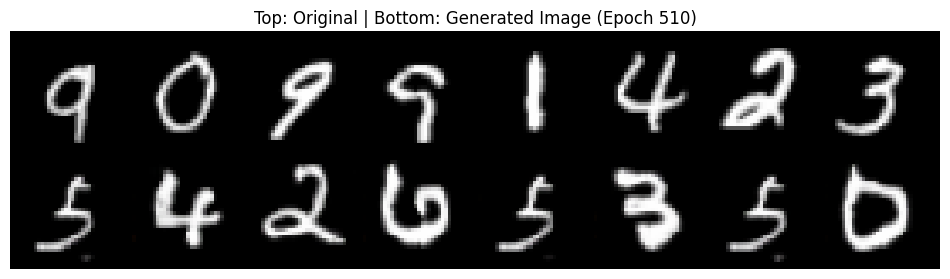

Epoch-511/1000: 100%|██████████| 469/469 [00:35<00:00, 13.18it/s, GenLoss=5.68, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.51633451539062
Discriminator Loss: 0.2042432358778362


Epoch-512/1000: 100%|██████████| 469/469 [00:36<00:00, 13.01it/s, GenLoss=5.38, DisLoss=0.202, DisSteps=1] 


Generator Loss: 4.169555883163582
Discriminator Loss: 0.2209478091520033


Epoch-513/1000: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s, GenLoss=4.82, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.002732572525041
Discriminator Loss: 0.21949766544517932


Epoch-514/1000: 100%|██████████| 469/469 [00:35<00:00, 13.21it/s, GenLoss=5.42, DisLoss=0.186, DisSteps=1]


Generator Loss: 3.8569599158728303
Discriminator Loss: 0.21612524309519257


Epoch-515/1000: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s, GenLoss=3.58, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.293025897255839
Discriminator Loss: 0.2285082548666102


Epoch-516/1000: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s, GenLoss=4.09, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.4366515968908375
Discriminator Loss: 0.20818879609423152


Epoch-517/1000: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s, GenLoss=5.05, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.586984112318645
Discriminator Loss: 0.1966817473043511


Epoch-518/1000: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s, GenLoss=5.37, DisLoss=0.32, DisSteps=1] 


Generator Loss: 4.3636105291879
Discriminator Loss: 0.20742677215701227


Epoch-519/1000: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s, GenLoss=4.22, DisLoss=0.209, DisSteps=1]


Generator Loss: 4.606768251736281
Discriminator Loss: 0.20017252506604835


Epoch-520/1000: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s, GenLoss=7.07, DisLoss=0.246, DisSteps=1]


Generator Loss: 4.834794167008227
Discriminator Loss: 0.19519896268336248


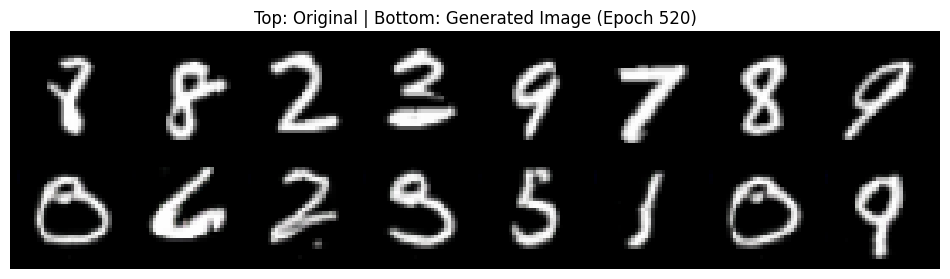

Epoch-521/1000: 100%|██████████| 469/469 [00:34<00:00, 13.40it/s, GenLoss=4.82, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.550817799720683
Discriminator Loss: 0.1994797544819968


Epoch-522/1000: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s, GenLoss=5.31, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.577014286635019
Discriminator Loss: 0.201911042335191


Epoch-523/1000: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s, GenLoss=3.23, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.524812821386211
Discriminator Loss: 0.1983299007865666


Epoch-524/1000: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s, GenLoss=5.02, DisLoss=0.208, DisSteps=1]


Generator Loss: 4.017978558916527
Discriminator Loss: 0.21127953639289718


Epoch-525/1000: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s, GenLoss=4.96, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.547436269361581
Discriminator Loss: 0.20444449915814755


Epoch-526/1000: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s, GenLoss=4.21, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.344362777687594
Discriminator Loss: 0.2051230851076305


Epoch-527/1000: 100%|██████████| 469/469 [00:35<00:00, 13.14it/s, GenLoss=4.31, DisLoss=0.254, DisSteps=1]


Generator Loss: 4.722374334518335
Discriminator Loss: 0.19727884156744618


Epoch-528/1000: 100%|██████████| 469/469 [00:35<00:00, 13.20it/s, GenLoss=5.37, DisLoss=0.22, DisSteps=1] 


Generator Loss: 4.488261323239503
Discriminator Loss: 0.20808372765715952


Epoch-529/1000: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s, GenLoss=3.9, DisLoss=0.223, DisSteps=1] 


Generator Loss: 4.597473772095719
Discriminator Loss: 0.20002877311920053


Epoch-530/1000: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s, GenLoss=4.74, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.495397501154495
Discriminator Loss: 0.2070028885150515


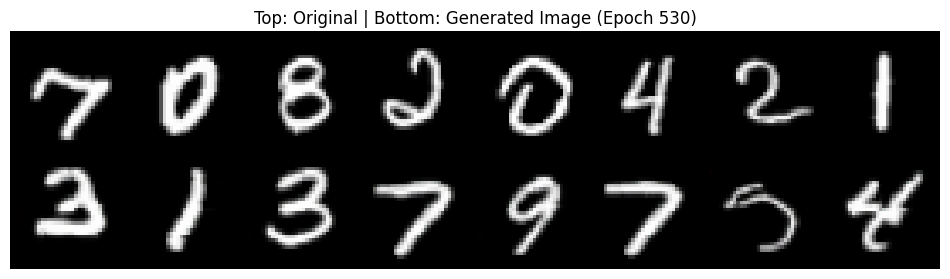

Epoch-531/1000: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s, GenLoss=3.68, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.934189913369445
Discriminator Loss: 0.198299633192101


Epoch-532/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=4.27, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.547413151909802
Discriminator Loss: 0.19684352272990416


Epoch-533/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=2.77, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.549825956572348
Discriminator Loss: 0.20275239271522838


Epoch-534/1000: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s, GenLoss=2.26, DisLoss=0.233, DisSteps=1]


Generator Loss: 4.3955940760529115
Discriminator Loss: 0.20841939099180673


Epoch-535/1000: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s, GenLoss=3.9, DisLoss=0.175, DisSteps=1] 


Generator Loss: 4.4275533781885335
Discriminator Loss: 0.2004691570488883


Epoch-536/1000: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s, GenLoss=2.96, DisLoss=0.214, DisSteps=1]


Generator Loss: 4.275231272172826
Discriminator Loss: 0.21077922930214196


Epoch-537/1000: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s, GenLoss=3.36, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.118945856846726
Discriminator Loss: 0.21330792906441923


Epoch-538/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=3.34, DisLoss=0.22, DisSteps=1] 


Generator Loss: 4.462003893435383
Discriminator Loss: 0.2072571865848895


Epoch-539/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=2.94, DisLoss=0.246, DisSteps=1]


Generator Loss: 4.290585690978239
Discriminator Loss: 0.21237155737907393


Epoch-540/1000: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s, GenLoss=6.73, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.388315675609402
Discriminator Loss: 0.20361236995979667


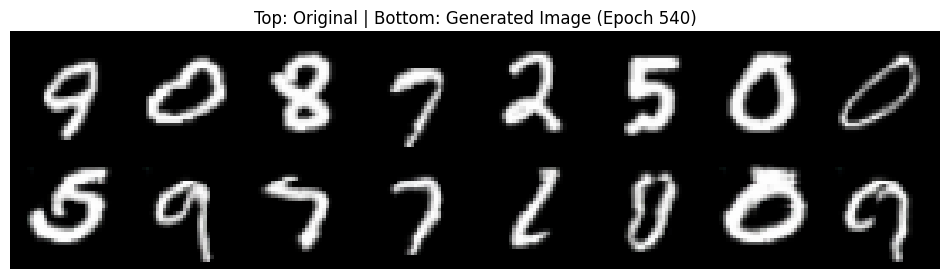

Epoch-541/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=4.77, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.5640833220248025
Discriminator Loss: 0.19874889268549775


Epoch-542/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=4.82, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.520923273903983
Discriminator Loss: 0.20348097263241627


Epoch-543/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=6.09, DisLoss=0.226, DisSteps=1]


Generator Loss: 4.451622988369419
Discriminator Loss: 0.19657424769040618


Epoch-544/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=6.03, DisLoss=0.279, DisSteps=1]


Generator Loss: 4.481747819924914
Discriminator Loss: 0.1984045008924216


Epoch-545/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=2.85, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.414097292336828
Discriminator Loss: 0.20280332952292998


Epoch-546/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=4.25, DisLoss=0.354, DisSteps=1]


Generator Loss: 4.530669763906678
Discriminator Loss: 0.19874113963356912


Epoch-547/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=5.85, DisLoss=0.254, DisSteps=1]


Generator Loss: 4.650010873513944
Discriminator Loss: 0.1989554760616217


Epoch-548/1000: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s, GenLoss=4.39, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.4588824996053535
Discriminator Loss: 0.20256629824511277


Epoch-549/1000: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s, GenLoss=4.22, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.78297921869038
Discriminator Loss: 0.20273302012542163


Epoch-550/1000: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s, GenLoss=5.24, DisLoss=0.304, DisSteps=1]


Generator Loss: 4.698257448830838
Discriminator Loss: 0.1950259338627492


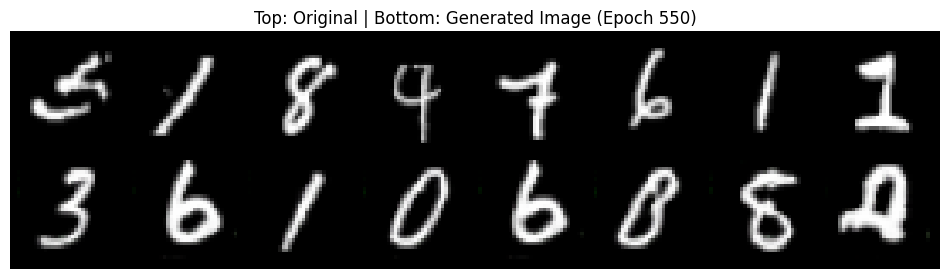

Epoch-551/1000: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s, GenLoss=3.41, DisLoss=0.195, DisSteps=1] 


Generator Loss: 4.3431234374991865
Discriminator Loss: 0.20761227547359873


Epoch-552/1000: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s, GenLoss=5.52, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.475678236499778
Discriminator Loss: 0.2015340666908191


Epoch-553/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=5.5, DisLoss=0.201, DisSteps=1] 


Generator Loss: 4.1048627164063936
Discriminator Loss: 0.20611554921181727


Epoch-554/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=5.24, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.305270850531328
Discriminator Loss: 0.207607898567277


Epoch-555/1000: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s, GenLoss=5.85, DisLoss=0.183, DisSteps=1]


Generator Loss: 3.9322671315817437
Discriminator Loss: 0.21416566099947704


Epoch-556/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=3.61, DisLoss=0.233, DisSteps=1]


Generator Loss: 3.974066327121466
Discriminator Loss: 0.21588672541860324


Epoch-557/1000: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s, GenLoss=6.53, DisLoss=0.196, DisSteps=1] 


Generator Loss: 4.116761413464414
Discriminator Loss: 0.22045609462998314


Epoch-558/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=5.25, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.54317943983749
Discriminator Loss: 0.20236590437924684


Epoch-559/1000: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s, GenLoss=5.41, DisLoss=0.225, DisSteps=1]


Generator Loss: 4.665610912766284
Discriminator Loss: 0.2047451112443196


Epoch-560/1000: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s, GenLoss=3.82, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.452124846769548
Discriminator Loss: 0.198532952651032


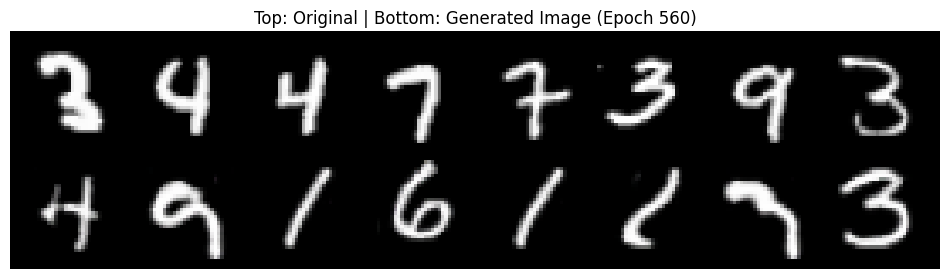

Epoch-561/1000: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s, GenLoss=5.39, DisLoss=0.196, DisSteps=1]


Generator Loss: 4.599829078483175
Discriminator Loss: 0.19732751447890104


Epoch-562/1000: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s, GenLoss=5.59, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.952345528836443
Discriminator Loss: 0.19332798565628687


Epoch-563/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=5, DisLoss=0.186, DisSteps=1]   


Generator Loss: 4.262764941400556
Discriminator Loss: 0.21105074164455634


Epoch-564/1000: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s, GenLoss=6.82, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.2080367559563125
Discriminator Loss: 0.20193194653560867


Epoch-565/1000: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s, GenLoss=6.01, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.296554618298626
Discriminator Loss: 0.20144770248358185


Epoch-566/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=3.34, DisLoss=0.216, DisSteps=1]


Generator Loss: 4.633811587717996
Discriminator Loss: 0.19507526604732725


Epoch-567/1000: 100%|██████████| 469/469 [00:32<00:00, 14.40it/s, GenLoss=4.29, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.711057956284805
Discriminator Loss: 0.20722601751783


Epoch-568/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=5.78, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.414085130447518
Discriminator Loss: 0.1974486002980519


Epoch-569/1000: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s, GenLoss=4.41, DisLoss=0.239, DisSteps=1]


Generator Loss: 4.492182536928384
Discriminator Loss: 0.19819377527943552


Epoch-570/1000: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s, GenLoss=4.2, DisLoss=0.18, DisSteps=1]  


Generator Loss: 4.565034294433431
Discriminator Loss: 0.19786316810894622


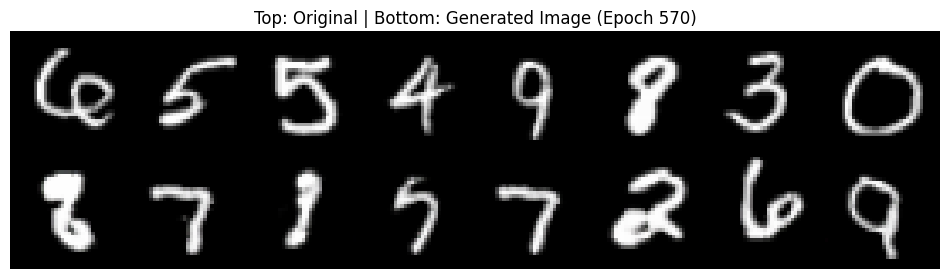

Epoch-571/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=5.42, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.416991449114102
Discriminator Loss: 0.20281006675412153


Epoch-572/1000: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s, GenLoss=4.31, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.479937487319589
Discriminator Loss: 0.2094107433549885


Epoch-573/1000: 100%|██████████| 469/469 [00:31<00:00, 15.11it/s, GenLoss=2.8, DisLoss=0.219, DisSteps=1] 


Generator Loss: 4.1937090473642735
Discriminator Loss: 0.20282751283665965


Epoch-574/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=7.1, DisLoss=0.236, DisSteps=1] 


Generator Loss: 4.5224665268651965
Discriminator Loss: 0.19861812978538115


Epoch-575/1000: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s, GenLoss=4.8, DisLoss=0.222, DisSteps=1] 


Generator Loss: 4.78332078533132
Discriminator Loss: 0.19708266152120602


Epoch-576/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=4.95, DisLoss=0.22, DisSteps=1] 


Generator Loss: 4.699905202332844
Discriminator Loss: 0.19943341927360625


Epoch-577/1000: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s, GenLoss=6.48, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.428846527010139
Discriminator Loss: 0.20408884224606982


Epoch-578/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=6.77, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.456864950753478
Discriminator Loss: 0.20264272836606895


Epoch-579/1000: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s, GenLoss=4.14, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.671385449387118
Discriminator Loss: 0.1955266373116833


Epoch-580/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=3.26, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.455433210584401
Discriminator Loss: 0.19971799672539556


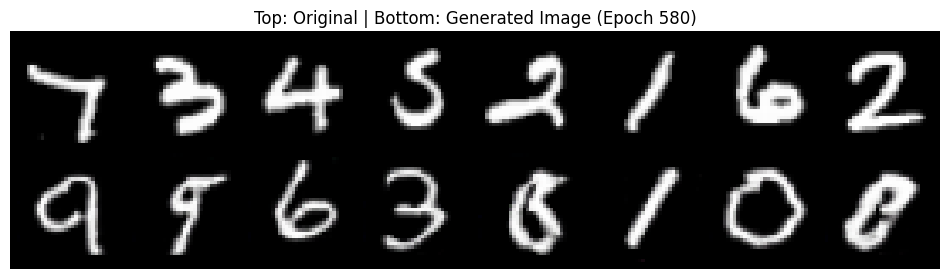

Epoch-581/1000: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s, GenLoss=4.16, DisLoss=0.457, DisSteps=1]


Generator Loss: 4.445245480486579
Discriminator Loss: 0.2026517659997635


Epoch-582/1000: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s, GenLoss=3.22, DisLoss=0.387, DisSteps=1]


Generator Loss: 4.120015314647129
Discriminator Loss: 0.2193475314485493


Epoch-583/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=3.75, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.190601877820518
Discriminator Loss: 0.21164814215987476


Epoch-584/1000: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s, GenLoss=4.59, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.071721951082063
Discriminator Loss: 0.210007748306433


Epoch-585/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=5.02, DisLoss=0.226, DisSteps=1]


Generator Loss: 4.343131784182876
Discriminator Loss: 0.20508708202762643


Epoch-586/1000: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s, GenLoss=3.42, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.548952952630993
Discriminator Loss: 0.1981404301708441


Epoch-587/1000: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s, GenLoss=3.18, DisLoss=0.256, DisSteps=1]


Generator Loss: 4.326435906800634
Discriminator Loss: 0.20312951911868318


Epoch-588/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=5.63, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.53352051757292
Discriminator Loss: 0.19749528919455847


Epoch-589/1000: 100%|██████████| 469/469 [00:31<00:00, 15.02it/s, GenLoss=2.98, DisLoss=0.271, DisSteps=1]


Generator Loss: 4.6142260519934615
Discriminator Loss: 0.2002522101534455


Epoch-590/1000: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s, GenLoss=5.03, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.328992493117034
Discriminator Loss: 0.20957222171048365


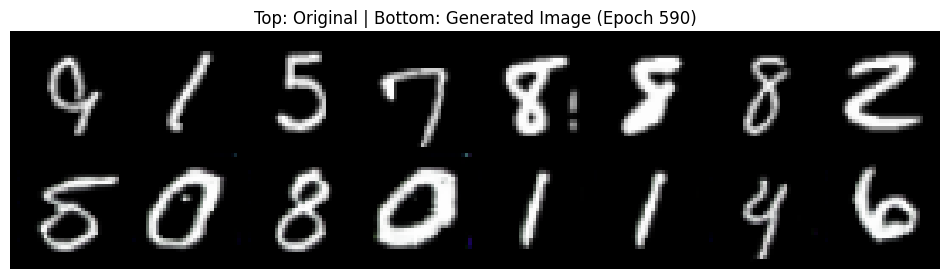

Epoch-591/1000: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s, GenLoss=4.32, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.294449851965345
Discriminator Loss: 0.20607371942829222


Epoch-592/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=4.74, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.590627642836906
Discriminator Loss: 0.20685041522674724


Epoch-593/1000: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s, GenLoss=3.74, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.6708815595996915
Discriminator Loss: 0.1977154949326505


Epoch-594/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=7.16, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.549264555546775
Discriminator Loss: 0.20040611045828252


Epoch-595/1000: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s, GenLoss=2.26, DisLoss=0.292, DisSteps=1]


Generator Loss: 4.225323102621636
Discriminator Loss: 0.21411100293654622


Epoch-596/1000: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s, GenLoss=3.4, DisLoss=0.214, DisSteps=1] 


Generator Loss: 4.538941469019664
Discriminator Loss: 0.2054070182827744


Epoch-597/1000: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s, GenLoss=4.86, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.735106186063559
Discriminator Loss: 0.20385924896705887


Epoch-598/1000: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s, GenLoss=5.18, DisLoss=0.181, DisSteps=1]


Generator Loss: 5.004366509695806
Discriminator Loss: 0.18751803046858895


Epoch-599/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=5.7, DisLoss=0.186, DisSteps=1] 


Generator Loss: 4.661436204462926
Discriminator Loss: 0.19157659842261374


Epoch-600/1000: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s, GenLoss=4.44, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.782279082198642
Discriminator Loss: 0.1937396723324302


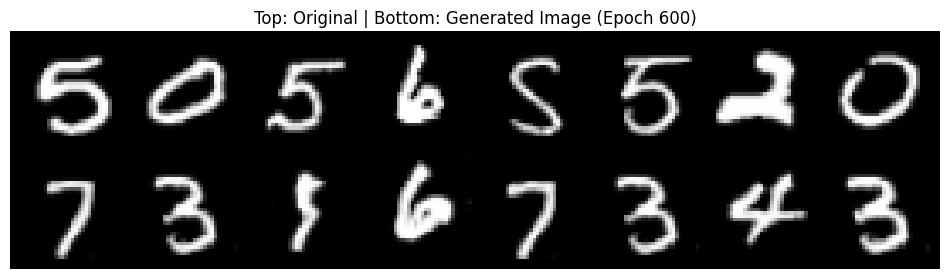

Epoch-601/1000: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s, GenLoss=6.1, DisLoss=0.188, DisSteps=1] 


Generator Loss: 4.72749928777406
Discriminator Loss: 0.19895224501964634


Epoch-602/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=5.28, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.629746559840529
Discriminator Loss: 0.1978982617415345


Epoch-603/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=5.43, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.4636893826507045
Discriminator Loss: 0.20149201825102256


Epoch-604/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=5.24, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.798032674199737
Discriminator Loss: 0.19639258293200657


Epoch-605/1000: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s, GenLoss=4.6, DisLoss=0.207, DisSteps=1] 


Generator Loss: 4.875094491027311
Discriminator Loss: 0.1923463575875581


Epoch-606/1000: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s, GenLoss=4.42, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.485526485737961
Discriminator Loss: 0.20429503199642401


Epoch-607/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=5.38, DisLoss=0.327, DisSteps=1]


Generator Loss: 4.438839807693384
Discriminator Loss: 0.2030653166237162


Epoch-608/1000: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s, GenLoss=5.99, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.2343608257867125
Discriminator Loss: 0.21101304930029138


Epoch-609/1000: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s, GenLoss=5.74, DisLoss=0.17, DisSteps=1] 


Generator Loss: 4.777767189784345
Discriminator Loss: 0.19942197022534636


Epoch-610/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=3.21, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.67201215219396
Discriminator Loss: 0.19449501851601386


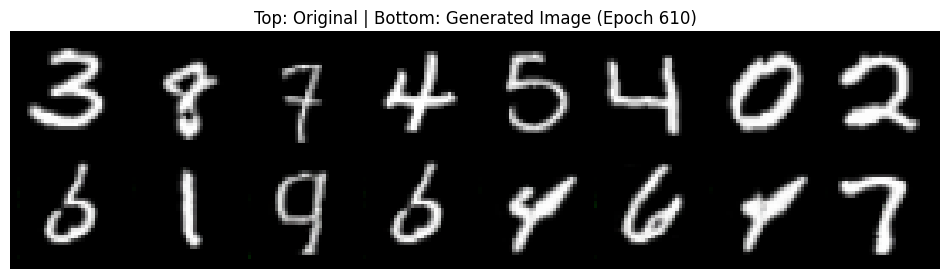

Epoch-611/1000: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s, GenLoss=5.06, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.2347577924667394
Discriminator Loss: 0.21063254602046919


Epoch-612/1000: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s, GenLoss=4.8, DisLoss=0.214, DisSteps=1] 


Generator Loss: 4.155213320433204
Discriminator Loss: 0.20920406660037255


Epoch-613/1000: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s, GenLoss=4.42, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.6737536804508295
Discriminator Loss: 0.20657119704589152


Epoch-614/1000: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s, GenLoss=4.5, DisLoss=0.195, DisSteps=1] 


Generator Loss: 4.4604857903299555
Discriminator Loss: 0.20101747577632667


Epoch-615/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=3.23, DisLoss=0.196, DisSteps=1]


Generator Loss: 4.2946938044989285
Discriminator Loss: 0.21462435302322608


Epoch-616/1000: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s, GenLoss=2.46, DisLoss=0.208, DisSteps=1]


Generator Loss: 4.363606867759721
Discriminator Loss: 0.20376685588980026


Epoch-617/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=6.05, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.424768632917262
Discriminator Loss: 0.20090849694412655


Epoch-618/1000: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s, GenLoss=4.66, DisLoss=0.232, DisSteps=1]


Generator Loss: 4.500075400256907
Discriminator Loss: 0.19662104858391322


Epoch-619/1000: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s, GenLoss=3.36, DisLoss=0.203, DisSteps=1] 


Generator Loss: 4.2091666513414525
Discriminator Loss: 0.2117706470842809


Epoch-620/1000: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s, GenLoss=4.98, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.171543840914647
Discriminator Loss: 0.20607688114333


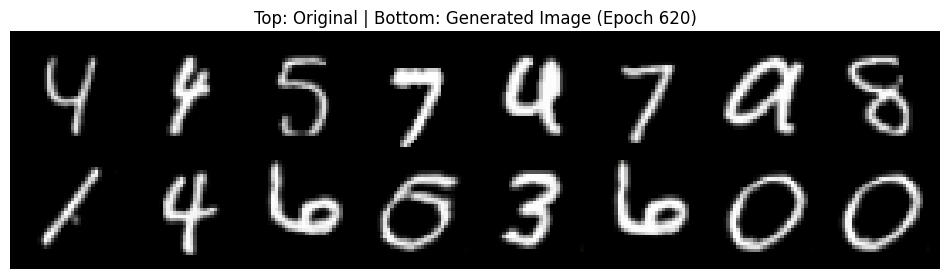

Epoch-621/1000: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s, GenLoss=4.53, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.328206990319274
Discriminator Loss: 0.21274106201332516


Epoch-622/1000: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s, GenLoss=2.4, DisLoss=0.263, DisSteps=1] 


Generator Loss: 4.331391360459806
Discriminator Loss: 0.2029824465322596


Epoch-623/1000: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s, GenLoss=3.34, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.2521802469103065
Discriminator Loss: 0.21234088440312507


Epoch-624/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=4.64, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.374860427781209
Discriminator Loss: 0.20916858556936543


Epoch-625/1000: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s, GenLoss=7.14, DisLoss=0.174, DisSteps=1]


Generator Loss: 5.02046156285414
Discriminator Loss: 0.1976117246123011


Epoch-626/1000: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s, GenLoss=2.12, DisLoss=0.269, DisSteps=1]


Generator Loss: 4.964891942325178
Discriminator Loss: 0.1986567017747395


Epoch-627/1000: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s, GenLoss=6.64, DisLoss=0.213, DisSteps=1]


Generator Loss: 4.824157795163869
Discriminator Loss: 0.19198361741327274


Epoch-628/1000: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s, GenLoss=5.58, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.917307677807838
Discriminator Loss: 0.19062175771702072


Epoch-629/1000: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s, GenLoss=3, DisLoss=0.176, DisSteps=1]   


Generator Loss: 4.467069373201968
Discriminator Loss: 0.20567933020434145


Epoch-630/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=2.77, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.297910092481926
Discriminator Loss: 0.20199606632754238


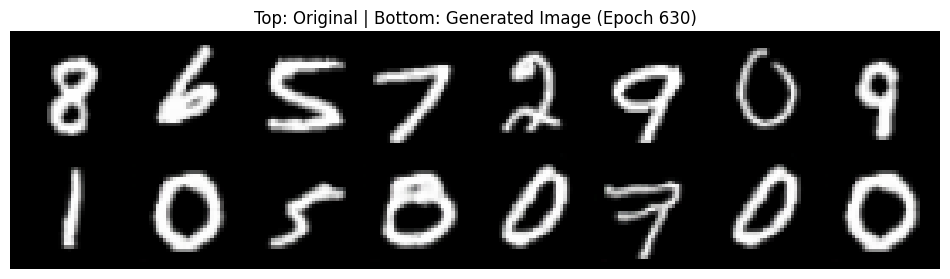

Epoch-631/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=5.19, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.457309089998192
Discriminator Loss: 0.19973622453111067


Epoch-632/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=2.81, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.2921253879949735
Discriminator Loss: 0.21260088065794028


Epoch-633/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=5.29, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.611340079480397
Discriminator Loss: 0.2005784762884254


Epoch-634/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=2.73, DisLoss=0.2, DisSteps=1]  


Generator Loss: 4.474181277665502
Discriminator Loss: 0.20311020025566442


Epoch-635/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=3, DisLoss=0.196, DisSteps=1]   


Generator Loss: 4.189318065195958
Discriminator Loss: 0.20962189522379243


Epoch-636/1000: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s, GenLoss=4.81, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.206108013449955
Discriminator Loss: 0.20093083524627725


Epoch-637/1000: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s, GenLoss=4.53, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.321534119181033
Discriminator Loss: 0.20828593724063718


Epoch-638/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=2.82, DisLoss=0.26, DisSteps=1] 


Generator Loss: 4.1982583437901315
Discriminator Loss: 0.20980961268136242


Epoch-639/1000: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s, GenLoss=4.3, DisLoss=0.188, DisSteps=1] 


Generator Loss: 4.263707852058573
Discriminator Loss: 0.20559776372619784


Epoch-640/1000: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s, GenLoss=5.05, DisLoss=0.204, DisSteps=1]


Generator Loss: 4.501420189576871
Discriminator Loss: 0.20665983401381893


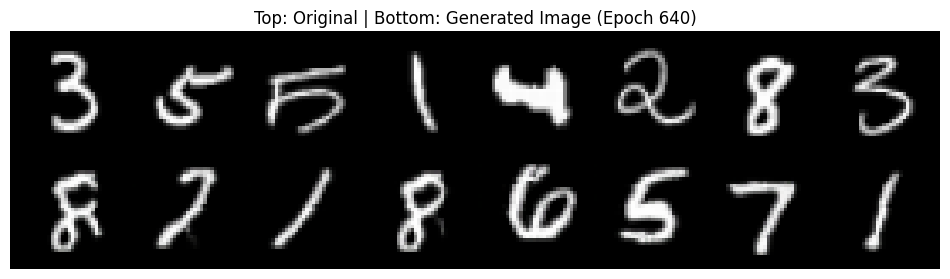

Epoch-641/1000: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s, GenLoss=4.99, DisLoss=0.231, DisSteps=1]


Generator Loss: 4.436725942819103
Discriminator Loss: 0.20241305660972717


Epoch-642/1000: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s, GenLoss=3.1, DisLoss=0.227, DisSteps=1] 


Generator Loss: 4.057089004435265
Discriminator Loss: 0.2138351877805775


Epoch-643/1000: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s, GenLoss=4.19, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.038704987019618
Discriminator Loss: 0.2207359291279494


Epoch-644/1000: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, GenLoss=6.21, DisLoss=0.229, DisSteps=1]


Generator Loss: 4.005448204876263
Discriminator Loss: 0.22089535763650053


Epoch-645/1000: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s, GenLoss=4.13, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.2168766575327306
Discriminator Loss: 0.20455002006310136


Epoch-646/1000: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s, GenLoss=4.79, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.486127917446307
Discriminator Loss: 0.20581801601056096


Epoch-647/1000: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, GenLoss=4.6, DisLoss=0.176, DisSteps=1] 


Generator Loss: 4.815435126392064
Discriminator Loss: 0.19770464088235581


Epoch-648/1000: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s, GenLoss=4.94, DisLoss=0.17, DisSteps=1] 


Generator Loss: 4.8280443865607285
Discriminator Loss: 0.19110159610888597


Epoch-649/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=4.67, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.578153490766025
Discriminator Loss: 0.19692624619266372


Epoch-650/1000: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s, GenLoss=3.19, DisLoss=0.271, DisSteps=1]


Generator Loss: 4.497537857179703
Discriminator Loss: 0.20088620220166026


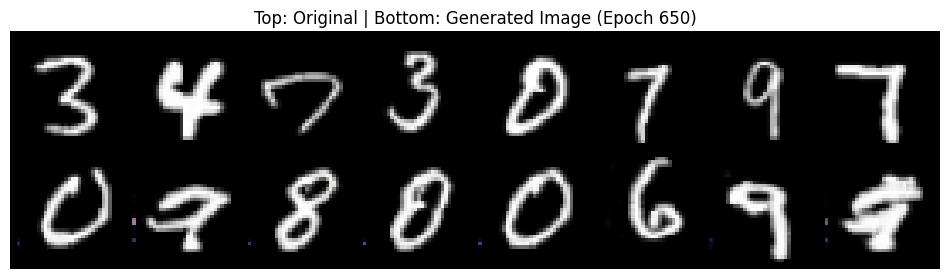

Epoch-651/1000: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s, GenLoss=3.39, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.347411975931766
Discriminator Loss: 0.20071050883737454


Epoch-652/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=1.58, DisLoss=0.285, DisSteps=1]


Generator Loss: 4.388725853678006
Discriminator Loss: 0.20764311792245552


Epoch-653/1000: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s, GenLoss=2.79, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.485903304522988
Discriminator Loss: 0.20940393438217228


Epoch-654/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=3.49, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.040986213856923
Discriminator Loss: 0.20917603964490422


Epoch-655/1000: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s, GenLoss=4.28, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.087974603242203
Discriminator Loss: 0.22138983703879658


Epoch-656/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s, GenLoss=5.59, DisLoss=0.23, DisSteps=1] 


Generator Loss: 4.616815731977857
Discriminator Loss: 0.20576574734406178


Epoch-657/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=3.22, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.623883713537188
Discriminator Loss: 0.19984113890479113


Epoch-658/1000: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s, GenLoss=4.75, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.282807497835871
Discriminator Loss: 0.20300803659185926


Epoch-659/1000: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s, GenLoss=2.63, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.275970286143614
Discriminator Loss: 0.20404895555490116


Epoch-660/1000: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s, GenLoss=4.45, DisLoss=0.223, DisSteps=1]


Generator Loss: 4.147057325855247
Discriminator Loss: 0.20556713770955864


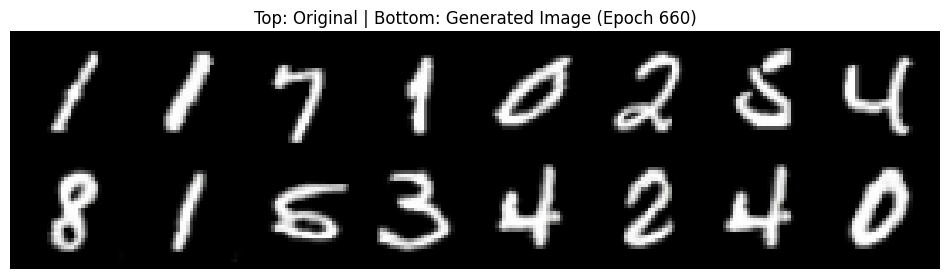

Epoch-661/1000: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s, GenLoss=6.47, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.236706928657824
Discriminator Loss: 0.21599360827062683


Epoch-662/1000: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, GenLoss=4.27, DisLoss=0.221, DisSteps=1]


Generator Loss: 3.9455582686324617
Discriminator Loss: 0.2145368409817661


Epoch-663/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, GenLoss=3.59, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.107048855661583
Discriminator Loss: 0.20444431411686229


Epoch-664/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s, GenLoss=3.63, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.3597461023310355
Discriminator Loss: 0.20321581167961233


Epoch-665/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s, GenLoss=5.04, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.224669132659685
Discriminator Loss: 0.21315794878168656


Epoch-666/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=5.26, DisLoss=0.277, DisSteps=1]


Generator Loss: 4.297060913622761
Discriminator Loss: 0.21054396608363846


Epoch-667/1000: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s, GenLoss=5.49, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.610098021371024
Discriminator Loss: 0.19684987701078469


Epoch-668/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, GenLoss=5.54, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.47012660803317
Discriminator Loss: 0.20424592425065763


Epoch-669/1000: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, GenLoss=5.1, DisLoss=0.22, DisSteps=1]  


Generator Loss: 4.579209712014269
Discriminator Loss: 0.20014127104012952


Epoch-670/1000: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, GenLoss=4.41, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.493232176502122
Discriminator Loss: 0.20529099707918635


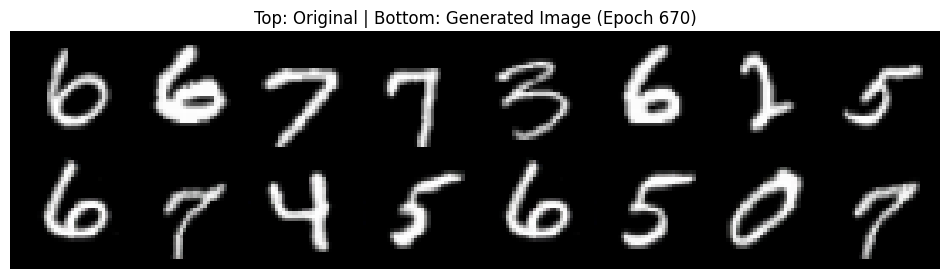

Epoch-671/1000: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, GenLoss=3.98, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.420355802405872
Discriminator Loss: 0.19870588091263638


Epoch-672/1000: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s, GenLoss=4.93, DisLoss=0.354, DisSteps=1]


Generator Loss: 4.651833143061412
Discriminator Loss: 0.20053885626132045


Epoch-673/1000: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s, GenLoss=3.29, DisLoss=0.187, DisSteps=1]


Generator Loss: 4.335520121588636
Discriminator Loss: 0.20640271606602903


Epoch-674/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s, GenLoss=4.82, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.334873447031863
Discriminator Loss: 0.20518237072775866


Epoch-675/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s, GenLoss=4.93, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.285282889917207
Discriminator Loss: 0.20598409024637138


Epoch-676/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s, GenLoss=4.96, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.2760988095167605
Discriminator Loss: 0.2075845638254304


Epoch-677/1000: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s, GenLoss=2.92, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.1065435236705135
Discriminator Loss: 0.2117085470827912


Epoch-678/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=4.62, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.255553508872416
Discriminator Loss: 0.21146433662249844


Epoch-679/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=5.63, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.32489445189169
Discriminator Loss: 0.20320770446298472


Epoch-680/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, GenLoss=5.63, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.727081383215085
Discriminator Loss: 0.20506127486859305


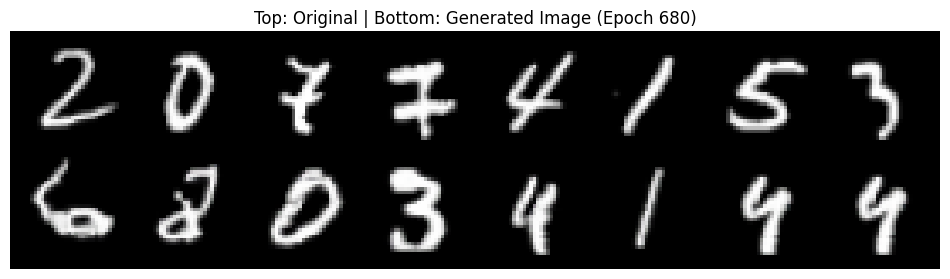

Epoch-681/1000: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s, GenLoss=3.75, DisLoss=0.215, DisSteps=1]


Generator Loss: 4.524495753906429
Discriminator Loss: 0.19681238696010891


Epoch-682/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s, GenLoss=4.32, DisLoss=0.307, DisSteps=1]


Generator Loss: 4.605750774778029
Discriminator Loss: 0.2014682849269432


Epoch-683/1000: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s, GenLoss=6.17, DisLoss=0.187, DisSteps=1]


Generator Loss: 3.9902763125230507
Discriminator Loss: 0.2113273966985979


Epoch-684/1000: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s, GenLoss=4.59, DisLoss=0.196, DisSteps=1]


Generator Loss: 4.205274971055069
Discriminator Loss: 0.2143288451725486


Epoch-685/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=4.36, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.1660683625288355
Discriminator Loss: 0.2102538388230399


Epoch-686/1000: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s, GenLoss=3.5, DisLoss=0.193, DisSteps=1] 


Generator Loss: 3.937742475761788
Discriminator Loss: 0.2191757907681882


Epoch-687/1000: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s, GenLoss=3.28, DisLoss=0.199, DisSteps=1]


Generator Loss: 3.83647213841298
Discriminator Loss: 0.21881406501666315


Epoch-688/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s, GenLoss=4.23, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.152916735931754
Discriminator Loss: 0.20724809741668865


Epoch-689/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=5.81, DisLoss=0.213, DisSteps=1]


Generator Loss: 4.003439799046466
Discriminator Loss: 0.22602716542637424


Epoch-690/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=3.67, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.026368081442583
Discriminator Loss: 0.21726120268103918


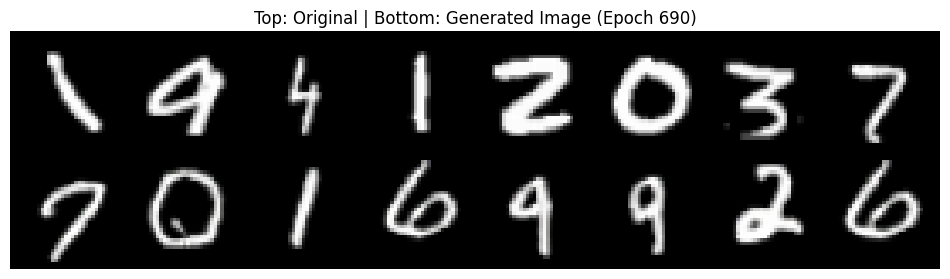

Epoch-691/1000: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s, GenLoss=6.48, DisLoss=0.224, DisSteps=1]


Generator Loss: 3.86583328069146
Discriminator Loss: 0.2226696650483715


Epoch-692/1000: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s, GenLoss=4.92, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.40715288556715
Discriminator Loss: 0.20688257037576582


Epoch-693/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=3.96, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.778750694636852
Discriminator Loss: 0.1990108943697232


Epoch-694/1000: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s, GenLoss=5.98, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.662783551063619
Discriminator Loss: 0.195236753934482


Epoch-695/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s, GenLoss=4.93, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.920831054004271
Discriminator Loss: 0.19139295721104913


Epoch-696/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s, GenLoss=4.63, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.650558262237354
Discriminator Loss: 0.18967696846421087


Epoch-697/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=5.08, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.354529567364691
Discriminator Loss: 0.20306346872086717


Epoch-698/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=4, DisLoss=0.215, DisSteps=1]   


Generator Loss: 4.457024067449671
Discriminator Loss: 0.2088339826318501


Epoch-699/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s, GenLoss=5.89, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.291627737250663
Discriminator Loss: 0.2065720948964548


Epoch-700/1000: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s, GenLoss=5.48, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.661285098427649
Discriminator Loss: 0.19830077321036285


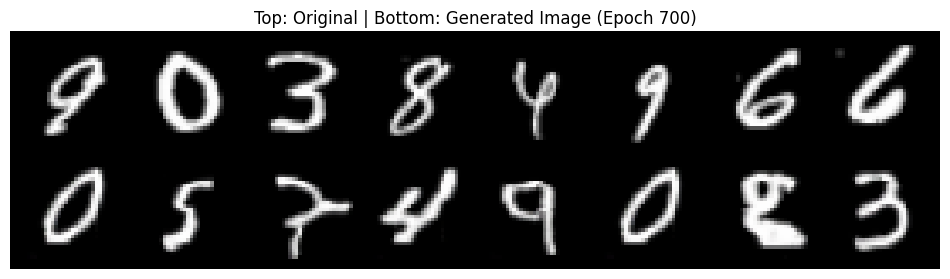

Epoch-701/1000: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s, GenLoss=3.78, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.549621797573846
Discriminator Loss: 0.1992292103292083


Epoch-702/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s, GenLoss=4.52, DisLoss=0.184, DisSteps=1] 


Generator Loss: 4.440193187199168
Discriminator Loss: 0.20904319169424745


Epoch-703/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=4.21, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.098491810786444
Discriminator Loss: 0.2097410830671091


Epoch-704/1000: 100%|██████████| 469/469 [00:28<00:00, 16.75it/s, GenLoss=5.66, DisLoss=0.336, DisSteps=1]


Generator Loss: 4.256052564456264
Discriminator Loss: 0.2040551762654583


Epoch-705/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s, GenLoss=6.3, DisLoss=0.205, DisSteps=1] 


Generator Loss: 4.391778691236906
Discriminator Loss: 0.20413314743336838


Epoch-706/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s, GenLoss=4.16, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.299956288164867
Discriminator Loss: 0.2012288783913228


Epoch-707/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s, GenLoss=1.71, DisLoss=0.274, DisSteps=1]


Generator Loss: 3.9803288470961644
Discriminator Loss: 0.21494772823761776


Epoch-708/1000: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s, GenLoss=6.25, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.247400928407844
Discriminator Loss: 0.20495214642110918


Epoch-709/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s, GenLoss=4.4, DisLoss=0.257, DisSteps=1] 


Generator Loss: 4.361340853705335
Discriminator Loss: 0.20223621623729593


Epoch-710/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=4.37, DisLoss=0.257, DisSteps=1]


Generator Loss: 4.446782268186622
Discriminator Loss: 0.20472178600236043


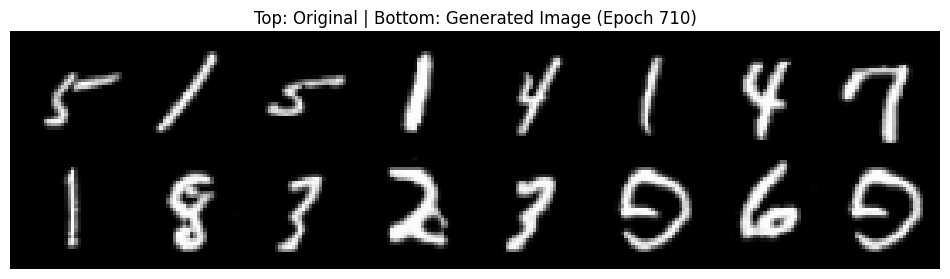

Epoch-711/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=4.94, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.613100443821726
Discriminator Loss: 0.20168520955007468


Epoch-712/1000: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s, GenLoss=3.38, DisLoss=0.314, DisSteps=1]


Generator Loss: 4.715120278187652
Discriminator Loss: 0.20218213684142017


Epoch-713/1000: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s, GenLoss=2.08, DisLoss=0.226, DisSteps=1]


Generator Loss: 4.2901533308313855
Discriminator Loss: 0.2068801593424669


Epoch-714/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=4.06, DisLoss=0.214, DisSteps=1]


Generator Loss: 4.3296687986804985
Discriminator Loss: 0.20520468316733964


Epoch-715/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s, GenLoss=2.29, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.336738773754665
Discriminator Loss: 0.20879778710763847


Epoch-716/1000: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, GenLoss=3.84, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.910716619318737
Discriminator Loss: 0.19569205681779492


Epoch-717/1000: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s, GenLoss=4.71, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.699086144788941
Discriminator Loss: 0.19604900167949163


Epoch-718/1000: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s, GenLoss=4.7, DisLoss=0.173, DisSteps=1] 


Generator Loss: 4.825112337750921
Discriminator Loss: 0.19260756792163036


Epoch-719/1000: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s, GenLoss=4.14, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.907974919276451
Discriminator Loss: 0.1929919469966563


Epoch-720/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=5.52, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.520222505780934
Discriminator Loss: 0.20200644150725813


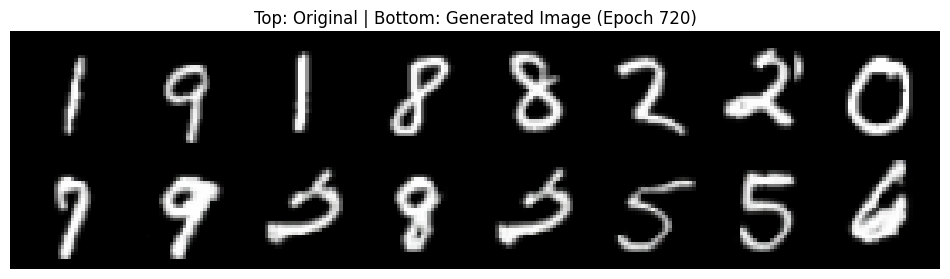

Epoch-721/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s, GenLoss=4.56, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.55231008372073
Discriminator Loss: 0.20017828641415658


Epoch-722/1000: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s, GenLoss=5.11, DisLoss=0.206, DisSteps=1]


Generator Loss: 4.367108524481116
Discriminator Loss: 0.20108439015554214


Epoch-723/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s, GenLoss=4.94, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.416365332694959
Discriminator Loss: 0.19790219358289673


Epoch-724/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=5.18, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.496390458109028
Discriminator Loss: 0.20502044358995677


Epoch-725/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s, GenLoss=5.13, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.524172514232237
Discriminator Loss: 0.2018014950030394


Epoch-726/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, GenLoss=3.7, DisLoss=0.177, DisSteps=1] 


Generator Loss: 4.111804907510021
Discriminator Loss: 0.20889059576525618


Epoch-727/1000: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, GenLoss=3.83, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.2547892754011825
Discriminator Loss: 0.2079166186008372


Epoch-728/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=3.4, DisLoss=0.197, DisSteps=1] 


Generator Loss: 4.454524394037373
Discriminator Loss: 0.20288535367959598


Epoch-729/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=5.58, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.483740335842694
Discriminator Loss: 0.19985359729225957


Epoch-730/1000: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, GenLoss=5.38, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.579631526332928
Discriminator Loss: 0.20433254501839945


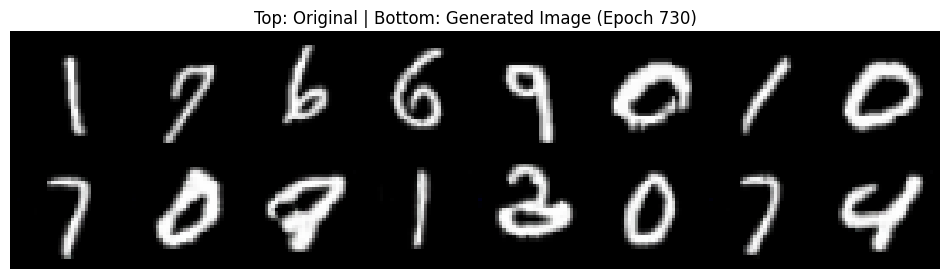

Epoch-731/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s, GenLoss=3.68, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.755858075898339
Discriminator Loss: 0.2084980063092734


Epoch-732/1000: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s, GenLoss=5.08, DisLoss=0.223, DisSteps=1]


Generator Loss: 4.646332879310478
Discriminator Loss: 0.20370034244396032


Epoch-733/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s, GenLoss=3.14, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.534262440097866
Discriminator Loss: 0.1935616476195199


Epoch-734/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, GenLoss=3.66, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.313194240334192
Discriminator Loss: 0.20175491629251793


Epoch-735/1000: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s, GenLoss=4.42, DisLoss=0.2, DisSteps=1]  


Generator Loss: 4.650814363951368
Discriminator Loss: 0.2001516850454721


Epoch-736/1000: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, GenLoss=7.32, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.764551802230542
Discriminator Loss: 0.20056554891153186


Epoch-737/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s, GenLoss=7.21, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.475438937703684
Discriminator Loss: 0.20308301558118386


Epoch-738/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=3.62, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.029259044986798
Discriminator Loss: 0.21361064497850088


Epoch-739/1000: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s, GenLoss=5.58, DisLoss=0.226, DisSteps=1]


Generator Loss: 3.9735142516174804
Discriminator Loss: 0.21769229778602942


Epoch-740/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, GenLoss=3.97, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.464455009523485
Discriminator Loss: 0.20035790930043407


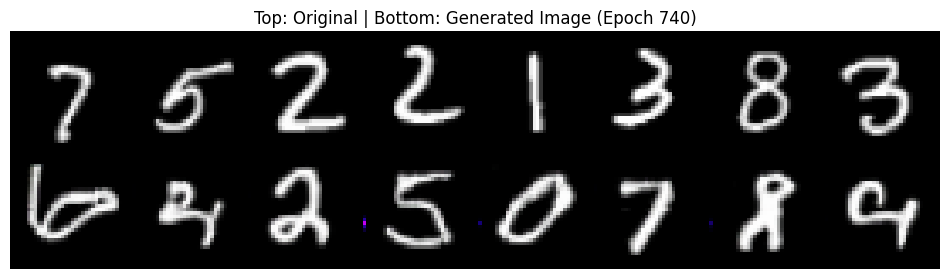

Epoch-741/1000: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s, GenLoss=6.13, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.681448546045624
Discriminator Loss: 0.19803836230021804


Epoch-742/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=3.83, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.38178798689771
Discriminator Loss: 0.20350242865238108


Epoch-743/1000: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s, GenLoss=4.94, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.199642745924911
Discriminator Loss: 0.2047378419876607


Epoch-744/1000: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, GenLoss=3.05, DisLoss=0.234, DisSteps=1]


Generator Loss: 4.42265105832106
Discriminator Loss: 0.2063815602615698


Epoch-745/1000: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s, GenLoss=2.85, DisLoss=0.198, DisSteps=1]


Generator Loss: 3.9388708234595846
Discriminator Loss: 0.2153540848732503


Epoch-746/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s, GenLoss=3.8, DisLoss=0.198, DisSteps=1] 


Generator Loss: 3.966237670577157
Discriminator Loss: 0.2150092765466491


Epoch-747/1000: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s, GenLoss=4.5, DisLoss=0.185, DisSteps=1] 


Generator Loss: 4.004357193832967
Discriminator Loss: 0.20683310525630838


Epoch-748/1000: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, GenLoss=4.29, DisLoss=0.224, DisSteps=1] 


Generator Loss: 3.992950861133746
Discriminator Loss: 0.21648490775241527


Epoch-749/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s, GenLoss=5.88, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.0556761880419145
Discriminator Loss: 0.20567869409315112


Epoch-750/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s, GenLoss=4.94, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.248251134144472
Discriminator Loss: 0.210981106198927


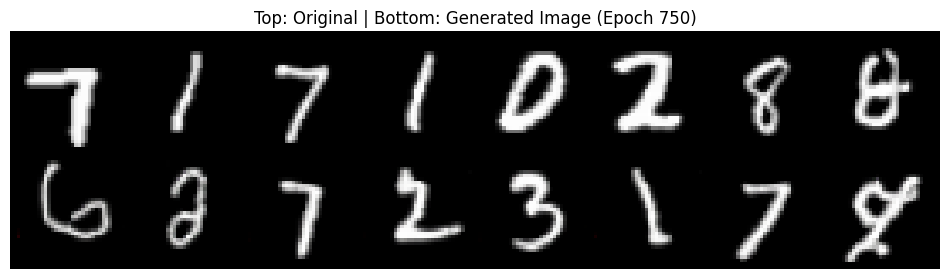

Epoch-751/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=3.57, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.044305639226299
Discriminator Loss: 0.2106366730384481


Epoch-752/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=3.69, DisLoss=0.346, DisSteps=1]


Generator Loss: 4.041577527009602
Discriminator Loss: 0.21520733709401413


Epoch-753/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=2.02, DisLoss=0.252, DisSteps=1]


Generator Loss: 4.084014761422488
Discriminator Loss: 0.2093082833836582


Epoch-754/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s, GenLoss=4.38, DisLoss=0.184, DisSteps=1] 


Generator Loss: 3.857261511308552
Discriminator Loss: 0.21954840898259617


Epoch-755/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=2.64, DisLoss=0.473, DisSteps=1]


Generator Loss: 3.919593168728387
Discriminator Loss: 0.2199480718196328


Epoch-756/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=4.84, DisLoss=0.187, DisSteps=1]


Generator Loss: 4.081437997980667
Discriminator Loss: 0.2137953724179949


Epoch-757/1000: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s, GenLoss=5.3, DisLoss=0.221, DisSteps=1] 


Generator Loss: 4.451992250454706
Discriminator Loss: 0.20880193798653862


Epoch-758/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s, GenLoss=4.37, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.351118918929273
Discriminator Loss: 0.2064092534183185


Epoch-759/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s, GenLoss=3.21, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.116658129925921
Discriminator Loss: 0.21272111761925824


Epoch-760/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=4.87, DisLoss=0.194, DisSteps=1]


Generator Loss: 4.2545775762244835
Discriminator Loss: 0.208160557726553


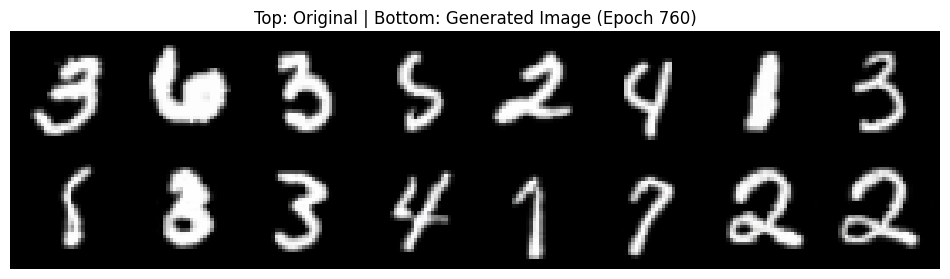

Epoch-761/1000: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s, GenLoss=5.14, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.793390814683585
Discriminator Loss: 0.20040199192348065


Epoch-762/1000: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s, GenLoss=4.68, DisLoss=0.217, DisSteps=1]


Generator Loss: 4.310072748391613
Discriminator Loss: 0.20565955807913594


Epoch-763/1000: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s, GenLoss=6.51, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.094762745442421
Discriminator Loss: 0.2112974844444027


Epoch-764/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=5.33, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.673046627786876
Discriminator Loss: 0.20077310283300973


Epoch-765/1000: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s, GenLoss=4.91, DisLoss=0.21, DisSteps=1] 


Generator Loss: 5.074354739585665
Discriminator Loss: 0.19256776838160272


Epoch-766/1000: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s, GenLoss=3.96, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.5661217693581
Discriminator Loss: 0.21164214957370434


Epoch-767/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s, GenLoss=5.64, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.300798766140236
Discriminator Loss: 0.20539000655796483


Epoch-768/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s, GenLoss=5.47, DisLoss=0.194, DisSteps=1]


Generator Loss: 4.301657550116338
Discriminator Loss: 0.2053550598400234


Epoch-769/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=2.57, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.096451475167834
Discriminator Loss: 0.21354201092903038


Epoch-770/1000: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s, GenLoss=4.66, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.423620577305873
Discriminator Loss: 0.20268185001446495


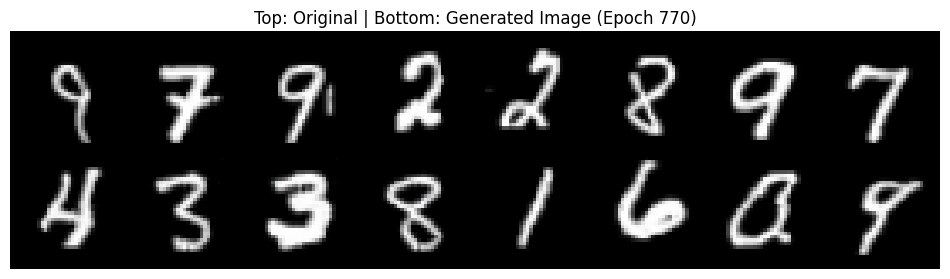

Epoch-771/1000: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s, GenLoss=3.56, DisLoss=0.235, DisSteps=1]


Generator Loss: 4.203873295519652
Discriminator Loss: 0.20712908311312134


Epoch-772/1000: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s, GenLoss=3.18, DisLoss=0.231, DisSteps=1]


Generator Loss: 4.161247716021182
Discriminator Loss: 0.2110392527857315


Epoch-773/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=4.91, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.387444589183783
Discriminator Loss: 0.210054334133927


Epoch-774/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=4.6, DisLoss=0.261, DisSteps=1] 


Generator Loss: 4.43177671422328
Discriminator Loss: 0.20318228892807258


Epoch-775/1000: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s, GenLoss=6.19, DisLoss=0.214, DisSteps=1]


Generator Loss: 4.719801774157136
Discriminator Loss: 0.19425553925383066


Epoch-776/1000: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s, GenLoss=3.42, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.53355038293135
Discriminator Loss: 0.20260871530595873


Epoch-777/1000: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s, GenLoss=3.55, DisLoss=0.234, DisSteps=1]


Generator Loss: 4.474341529264633
Discriminator Loss: 0.20063061297321116


Epoch-778/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s, GenLoss=6.14, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.389787726564957
Discriminator Loss: 0.20258643733921336


Epoch-779/1000: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s, GenLoss=5.04, DisLoss=0.245, DisSteps=1]


Generator Loss: 4.489190169234774
Discriminator Loss: 0.2021946758667289


Epoch-780/1000: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s, GenLoss=4.3, DisLoss=0.465, DisSteps=1] 


Generator Loss: 4.575878387066855
Discriminator Loss: 0.20623744519026294


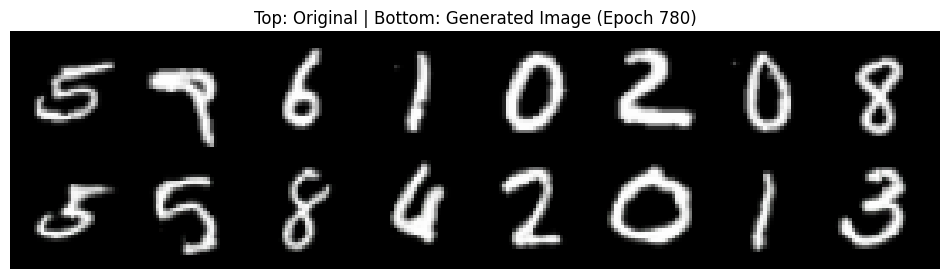

Epoch-781/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=5.18, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.42296397228485
Discriminator Loss: 0.20725950824299347


Epoch-782/1000: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s, GenLoss=3.49, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.441550401736424
Discriminator Loss: 0.20055059294329522


Epoch-783/1000: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s, GenLoss=5.31, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.418606019731778
Discriminator Loss: 0.21140413262696664


Epoch-784/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=5.59, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.336798140743394
Discriminator Loss: 0.20622102137821824


Epoch-785/1000: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s, GenLoss=3.63, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.294111347910183
Discriminator Loss: 0.19890881706275412


Epoch-786/1000: 100%|██████████| 469/469 [00:28<00:00, 16.75it/s, GenLoss=5.58, DisLoss=0.255, DisSteps=1]


Generator Loss: 4.164809188100575
Discriminator Loss: 0.20572334715425333


Epoch-787/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, GenLoss=4.19, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.216748662594793
Discriminator Loss: 0.20419017335118006


Epoch-788/1000: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s, GenLoss=5.08, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.55796332552489
Discriminator Loss: 0.20289031500374077


Epoch-789/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s, GenLoss=4.95, DisLoss=0.17, DisSteps=1] 


Generator Loss: 4.398820240360333
Discriminator Loss: 0.20409134020810443


Epoch-790/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=4.36, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.504643204369779
Discriminator Loss: 0.2009057271073876


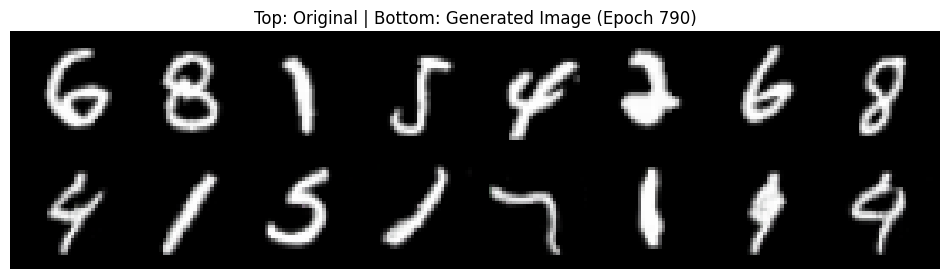

Epoch-791/1000: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s, GenLoss=5.03, DisLoss=0.331, DisSteps=1]


Generator Loss: 4.522765841819584
Discriminator Loss: 0.20934067444125218


Epoch-792/1000: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s, GenLoss=5.62, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.525150616794253
Discriminator Loss: 0.19905784548218572


Epoch-793/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, GenLoss=3.02, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.27283794056378
Discriminator Loss: 0.20867462605555684


Epoch-794/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=2.88, DisLoss=0.207, DisSteps=1]


Generator Loss: 4.179565039016545
Discriminator Loss: 0.2083580958754269


Epoch-795/1000: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s, GenLoss=3.66, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.10411989078847
Discriminator Loss: 0.22305526929115183


Epoch-796/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=4.66, DisLoss=0.187, DisSteps=1]


Generator Loss: 4.12065184167199
Discriminator Loss: 0.2121238140091459


Epoch-797/1000: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s, GenLoss=5.95, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.202317172022008
Discriminator Loss: 0.2083938597743191


Epoch-798/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=4.97, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.714185168239862
Discriminator Loss: 0.19208647240834958


Epoch-799/1000: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s, GenLoss=4.28, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.267028764621027
Discriminator Loss: 0.20552303491116586


Epoch-800/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=3.47, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.352038465583248
Discriminator Loss: 0.2005910949666363


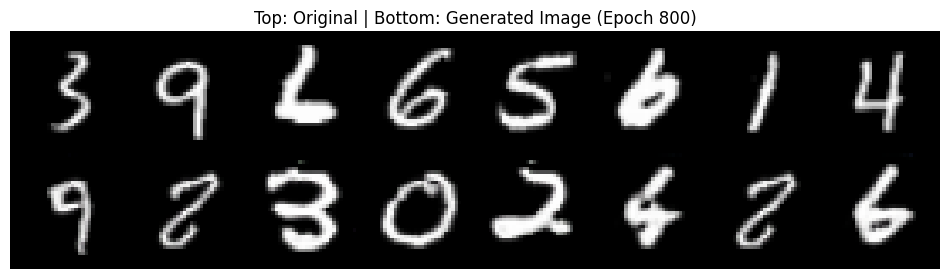

Epoch-801/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=4.48, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.215135465552812
Discriminator Loss: 0.20659196678636424


Epoch-802/1000: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, GenLoss=5.09, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.348666747495818
Discriminator Loss: 0.21119592963124134


Epoch-803/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s, GenLoss=7.11, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.568431332675633
Discriminator Loss: 0.19760244878243283


Epoch-804/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, GenLoss=4.23, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.186666781460044
Discriminator Loss: 0.20355750585415724


Epoch-805/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, GenLoss=4.14, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.355088715360108
Discriminator Loss: 0.20404652205865775


Epoch-806/1000: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s, GenLoss=3.73, DisLoss=0.241, DisSteps=1]


Generator Loss: 4.648887029588858
Discriminator Loss: 0.20497805242345277


Epoch-807/1000: 100%|██████████| 469/469 [00:29<00:00, 16.12it/s, GenLoss=5.35, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.621862757943078
Discriminator Loss: 0.20818234484460055


Epoch-808/1000: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s, GenLoss=3.01, DisLoss=0.219, DisSteps=1]


Generator Loss: 4.665032465574838
Discriminator Loss: 0.20209845852877287


Epoch-809/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s, GenLoss=4.92, DisLoss=0.213, DisSteps=1]


Generator Loss: 4.546460938606181
Discriminator Loss: 0.19964113590051372


Epoch-810/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s, GenLoss=5.38, DisLoss=0.222, DisSteps=1]


Generator Loss: 4.515936735596484
Discriminator Loss: 0.19758583478200664


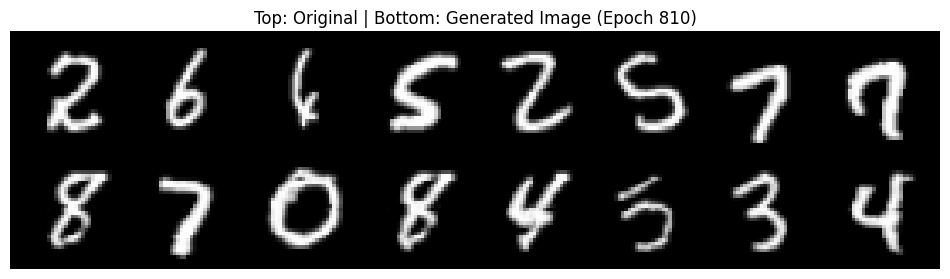

Epoch-811/1000: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s, GenLoss=4.83, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.288367541105763
Discriminator Loss: 0.20264296621274847


Epoch-812/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s, GenLoss=5.18, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.810183933803013
Discriminator Loss: 0.20489991562707083


Epoch-813/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=5.07, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.609926419217449
Discriminator Loss: 0.2042956809118104


Epoch-814/1000: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s, GenLoss=5.43, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.399985752380225
Discriminator Loss: 0.2021162432394048


Epoch-815/1000: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s, GenLoss=6.14, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.527704937371618
Discriminator Loss: 0.20258018920924872


Epoch-816/1000: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s, GenLoss=6.89, DisLoss=0.17, DisSteps=1] 


Generator Loss: 4.622820286862631
Discriminator Loss: 0.2013328388365093


Epoch-817/1000: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s, GenLoss=6.35, DisLoss=0.374, DisSteps=1]


Generator Loss: 4.417863069566836
Discriminator Loss: 0.2075046363479293


Epoch-818/1000: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s, GenLoss=5.63, DisLoss=0.222, DisSteps=1]


Generator Loss: 4.442528712978241
Discriminator Loss: 0.20399713214399465


Epoch-819/1000: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s, GenLoss=4.14, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.608131656768734
Discriminator Loss: 0.1983674290274252


Epoch-820/1000: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s, GenLoss=4.69, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.45466441589632
Discriminator Loss: 0.20161613462957492


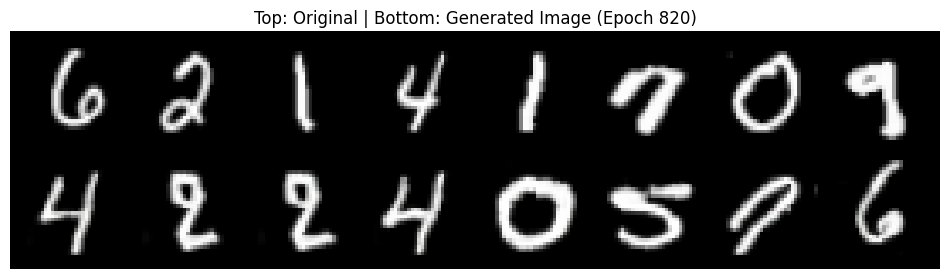

Epoch-821/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s, GenLoss=6.72, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.58109764376683
Discriminator Loss: 0.20349073572072393


Epoch-822/1000: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s, GenLoss=4.6, DisLoss=0.184, DisSteps=1] 


Generator Loss: 4.273588125639633
Discriminator Loss: 0.20125117643809776


Epoch-823/1000: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s, GenLoss=3.79, DisLoss=0.214, DisSteps=1]


Generator Loss: 4.353169080290967
Discriminator Loss: 0.19912635447628207


Epoch-824/1000: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s, GenLoss=4.16, DisLoss=0.351, DisSteps=1]


Generator Loss: 4.407639597270535
Discriminator Loss: 0.2151010774536682


Epoch-825/1000: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s, GenLoss=4.84, DisLoss=0.202, DisSteps=1]


Generator Loss: 3.946111276714024
Discriminator Loss: 0.2158280265356686


Epoch-826/1000: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s, GenLoss=3.84, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.801467474589724
Discriminator Loss: 0.20310220703768578


Epoch-827/1000: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s, GenLoss=5.07, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.1992362211508025
Discriminator Loss: 0.20676285644838296


Epoch-828/1000: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s, GenLoss=3.63, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.007074025648235
Discriminator Loss: 0.21171974163573942


Epoch-829/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=5.25, DisLoss=0.275, DisSteps=1]


Generator Loss: 4.023813031375536
Discriminator Loss: 0.21262561982628633


Epoch-830/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, GenLoss=3.46, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.276406177579721
Discriminator Loss: 0.20865141319186448


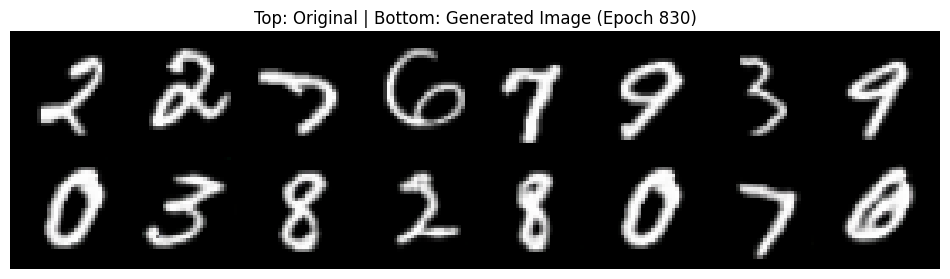

Epoch-831/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s, GenLoss=5.38, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.144094241199209
Discriminator Loss: 0.20192751641085407


Epoch-832/1000: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s, GenLoss=5.53, DisLoss=0.206, DisSteps=1]


Generator Loss: 4.412366734130551
Discriminator Loss: 0.20021734334258381


Epoch-833/1000: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s, GenLoss=4.45, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.564276602730822
Discriminator Loss: 0.20411533603408952


Epoch-834/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=6.76, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.475429564905065
Discriminator Loss: 0.2024267685692956


Epoch-835/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s, GenLoss=6.3, DisLoss=0.282, DisSteps=1] 


Generator Loss: 4.8289140147695155
Discriminator Loss: 0.1946848838377609


Epoch-836/1000: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s, GenLoss=2.17, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.8266500598077835
Discriminator Loss: 0.19792635843697895


Epoch-837/1000: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s, GenLoss=4.3, DisLoss=0.179, DisSteps=1] 


Generator Loss: 4.685968483943166
Discriminator Loss: 0.1938106457371193


Epoch-838/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s, GenLoss=4.2, DisLoss=0.179, DisSteps=1] 


Generator Loss: 4.742932980248669
Discriminator Loss: 0.19415280384930975


Epoch-839/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s, GenLoss=3.95, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.600422072512255
Discriminator Loss: 0.2019042427034012


Epoch-840/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=4.97, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.366160539675877
Discriminator Loss: 0.20226069236360888


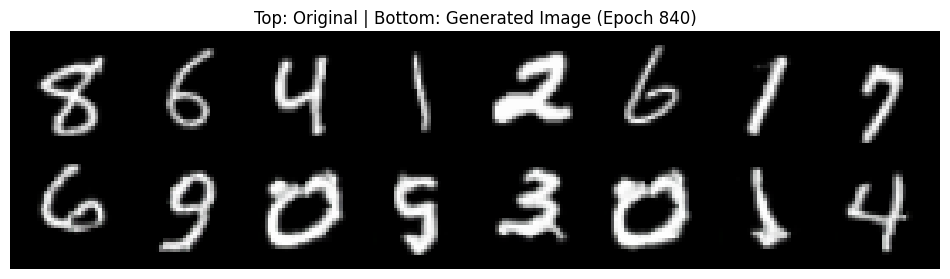

Epoch-841/1000: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s, GenLoss=5.74, DisLoss=0.49, DisSteps=1] 


Generator Loss: 4.235142086106323
Discriminator Loss: 0.21060799970936928


Epoch-842/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=4.15, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.387890086499358
Discriminator Loss: 0.21172978622572763


Epoch-843/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s, GenLoss=4.66, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.076465575425609
Discriminator Loss: 0.209300642805313


Epoch-844/1000: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s, GenLoss=4.09, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.332641781011878
Discriminator Loss: 0.20521544037597267


Epoch-845/1000: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s, GenLoss=4.61, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.207184686081241
Discriminator Loss: 0.20207137317418544


Epoch-846/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, GenLoss=4.48, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.444446779009121
Discriminator Loss: 0.19629450920802444


Epoch-847/1000: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s, GenLoss=5.16, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.582897577712785
Discriminator Loss: 0.2000967831944606


Epoch-848/1000: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s, GenLoss=1.96, DisLoss=0.321, DisSteps=1]


Generator Loss: 4.299781690528398
Discriminator Loss: 0.20555851822977128


Epoch-849/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=3.22, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.216219014958786
Discriminator Loss: 0.21748724119114216


Epoch-850/1000: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s, GenLoss=4.18, DisLoss=0.468, DisSteps=1]


Generator Loss: 4.182727942842918
Discriminator Loss: 0.20917505461142769


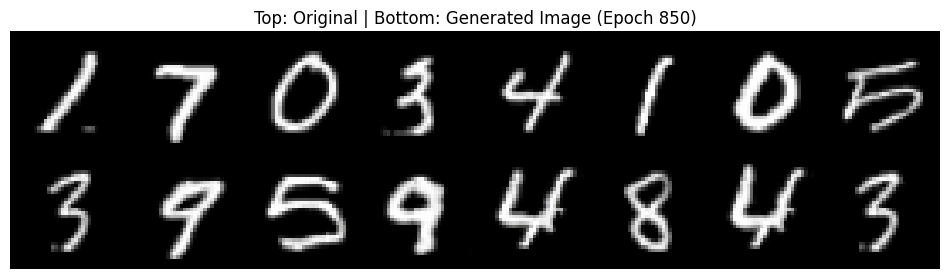

Epoch-851/1000: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s, GenLoss=4.48, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.085749398924903
Discriminator Loss: 0.20942255988049863


Epoch-852/1000: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s, GenLoss=5.74, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.122343304314847
Discriminator Loss: 0.20750941183648383


Epoch-853/1000: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s, GenLoss=2.5, DisLoss=0.202, DisSteps=1] 


Generator Loss: 4.328192560911687
Discriminator Loss: 0.20801023427230209


Epoch-854/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=3.79, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.045131715375986
Discriminator Loss: 0.21669661102772775


Epoch-855/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, GenLoss=4.13, DisLoss=0.244, DisSteps=1]


Generator Loss: 4.398430241196395
Discriminator Loss: 0.20251812403008881


Epoch-856/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=5.06, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.105466804016373
Discriminator Loss: 0.21479703555864565


Epoch-857/1000: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s, GenLoss=4.76, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.595867511814337
Discriminator Loss: 0.19955985829520073


Epoch-858/1000: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s, GenLoss=3.82, DisLoss=0.308, DisSteps=1]


Generator Loss: 4.596607610106722
Discriminator Loss: 0.20078831752226042


Epoch-859/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s, GenLoss=5.73, DisLoss=0.246, DisSteps=1]


Generator Loss: 4.180339068492084
Discriminator Loss: 0.21085510992292147


Epoch-860/1000: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s, GenLoss=5.3, DisLoss=0.284, DisSteps=1] 


Generator Loss: 4.569741211720367
Discriminator Loss: 0.2031823525677866


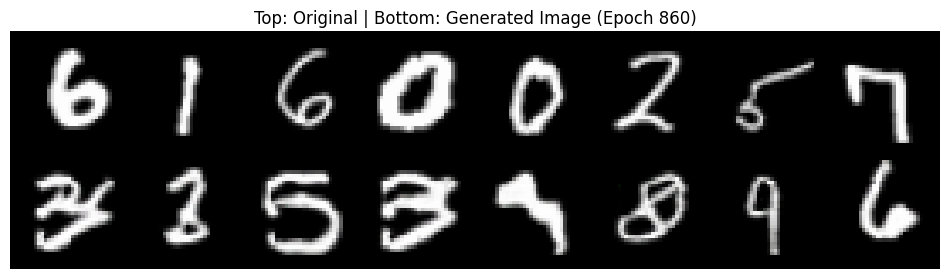

Epoch-861/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=2, DisLoss=0.214, DisSteps=1]   


Generator Loss: 4.4190370426503325
Discriminator Loss: 0.20662593546071287


Epoch-862/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=6.41, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.632119375759605
Discriminator Loss: 0.20184090822490294


Epoch-863/1000: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s, GenLoss=4.24, DisLoss=0.174, DisSteps=1]


Generator Loss: 4.962912304314977
Discriminator Loss: 0.19189725371439065


Epoch-864/1000: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s, GenLoss=6.15, DisLoss=0.17, DisSteps=1] 


Generator Loss: 4.710645997702186
Discriminator Loss: 0.1940844856472666


Epoch-865/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, GenLoss=5.23, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.806197227953848
Discriminator Loss: 0.1995135004014603


Epoch-866/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=5.1, DisLoss=0.177, DisSteps=1] 


Generator Loss: 4.949003966886606
Discriminator Loss: 0.1937612439714261


Epoch-867/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, GenLoss=3.91, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.682227542405443
Discriminator Loss: 0.1974120155008617


Epoch-868/1000: 100%|██████████| 469/469 [00:28<00:00, 16.29it/s, GenLoss=2.45, DisLoss=0.211, DisSteps=1]


Generator Loss: 4.653980445760145
Discriminator Loss: 0.2004062288414949


Epoch-869/1000: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s, GenLoss=4.33, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.50629521865072
Discriminator Loss: 0.20173334404985024


Epoch-870/1000: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s, GenLoss=5.05, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.44319558956984
Discriminator Loss: 0.20014909704102637


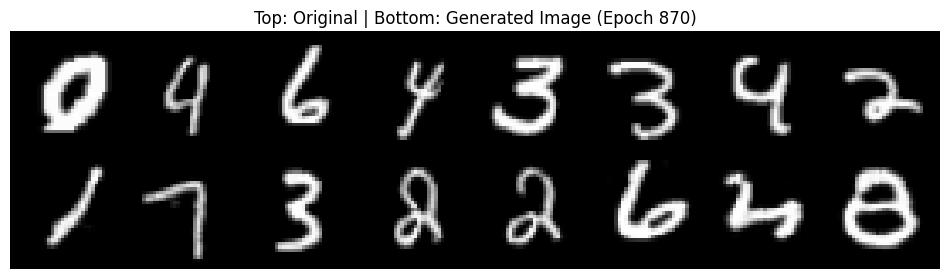

Epoch-871/1000: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s, GenLoss=6.34, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.529624270477783
Discriminator Loss: 0.2017437489047996


Epoch-872/1000: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s, GenLoss=3.82, DisLoss=0.182, DisSteps=1]


Generator Loss: 4.3711554462721605
Discriminator Loss: 0.20542820579588794


Epoch-873/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=4.78, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.583517499824069
Discriminator Loss: 0.2009110941942821


Epoch-874/1000: 100%|██████████| 469/469 [00:28<00:00, 16.22it/s, GenLoss=3.97, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.380712758757666
Discriminator Loss: 0.20078364948728192


Epoch-875/1000: 100%|██████████| 469/469 [00:28<00:00, 16.29it/s, GenLoss=3.08, DisLoss=0.2, DisSteps=1]  


Generator Loss: 4.563626592855718
Discriminator Loss: 0.1961511189241145


Epoch-876/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, GenLoss=3.81, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.650316595268656
Discriminator Loss: 0.19739445173409956


Epoch-877/1000: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s, GenLoss=4.68, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.459178384178991
Discriminator Loss: 0.20280084064774423


Epoch-878/1000: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s, GenLoss=5.81, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.607274327450978
Discriminator Loss: 0.191801916498111


Epoch-879/1000: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s, GenLoss=3.78, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.329164571599411
Discriminator Loss: 0.20379364973446454


Epoch-880/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=5.98, DisLoss=0.174, DisSteps=1] 


Generator Loss: 4.248496090806624
Discriminator Loss: 0.21848836426795926


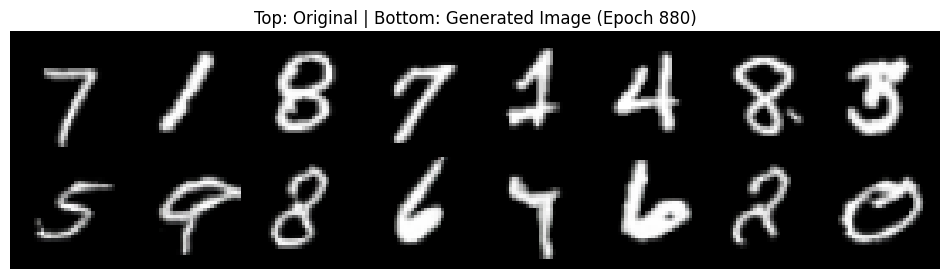

Epoch-881/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s, GenLoss=2.42, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.446798209188335
Discriminator Loss: 0.2050434211169733


Epoch-882/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s, GenLoss=5.47, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.237154700862828
Discriminator Loss: 0.21031378832326006


Epoch-883/1000: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, GenLoss=4.34, DisLoss=0.198, DisSteps=1]


Generator Loss: 4.233650360280262
Discriminator Loss: 0.2036176327067906


Epoch-884/1000: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s, GenLoss=4.55, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.4126353553617434
Discriminator Loss: 0.20051978477664084


Epoch-885/1000: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s, GenLoss=4.03, DisLoss=0.2, DisSteps=1]  


Generator Loss: 4.792834841112084
Discriminator Loss: 0.1927461103716893


Epoch-886/1000: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s, GenLoss=4.47, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.421958829294136
Discriminator Loss: 0.20156256409723367


Epoch-887/1000: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s, GenLoss=6.14, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.5343405300620265
Discriminator Loss: 0.19804923052091333


Epoch-888/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, GenLoss=5.42, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.606946853940675
Discriminator Loss: 0.19934664469665048


Epoch-889/1000: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, GenLoss=4.48, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.666914303419687
Discriminator Loss: 0.20104763814127014


Epoch-890/1000: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s, GenLoss=5.81, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.512963868915907
Discriminator Loss: 0.20194091163337358


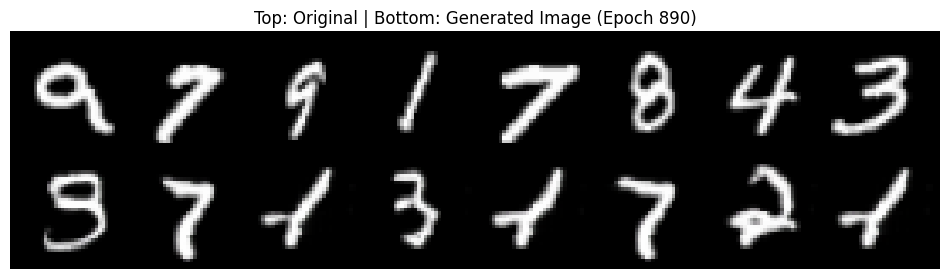

Epoch-891/1000: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s, GenLoss=4.84, DisLoss=0.187, DisSteps=1]


Generator Loss: 4.467575055195579
Discriminator Loss: 0.20443461152282097


Epoch-892/1000: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s, GenLoss=4.34, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.427969429284524
Discriminator Loss: 0.20465647132157772


Epoch-893/1000: 100%|██████████| 469/469 [00:29<00:00, 15.84it/s, GenLoss=5.63, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.430055112981084
Discriminator Loss: 0.20495576765745688


Epoch-894/1000: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s, GenLoss=5.31, DisLoss=0.303, DisSteps=1]


Generator Loss: 4.432639738389932
Discriminator Loss: 0.20276312974851524


Epoch-895/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=4.56, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.262162229145513
Discriminator Loss: 0.20189039853971397


Epoch-896/1000: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s, GenLoss=6, DisLoss=0.198, DisSteps=1]   


Generator Loss: 4.4355404074512315
Discriminator Loss: 0.19974010506037201


Epoch-897/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=4.6, DisLoss=0.171, DisSteps=1] 


Generator Loss: 4.427171744771604
Discriminator Loss: 0.19765070522390704


Epoch-898/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s, GenLoss=5.74, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.367634835527904
Discriminator Loss: 0.2110458995614733


Epoch-899/1000: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s, GenLoss=6.33, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.09658033710553
Discriminator Loss: 0.20878082494745884


Epoch-900/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s, GenLoss=3.24, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.350038137771428
Discriminator Loss: 0.20114440783890072


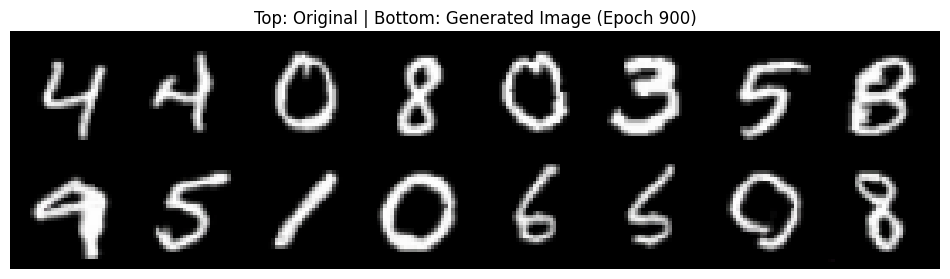

Epoch-901/1000: 100%|██████████| 469/469 [00:28<00:00, 16.75it/s, GenLoss=6.39, DisLoss=0.237, DisSteps=1]


Generator Loss: 4.382458481453121
Discriminator Loss: 0.205340889312311


Epoch-902/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=3.36, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.4828699867862625
Discriminator Loss: 0.20591181675508333


Epoch-903/1000: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s, GenLoss=3.64, DisLoss=0.188, DisSteps=1]


Generator Loss: 4.2381744267843935
Discriminator Loss: 0.20565125098360626


Epoch-904/1000: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s, GenLoss=2.45, DisLoss=0.268, DisSteps=1]


Generator Loss: 4.189618711024205
Discriminator Loss: 0.2068647160840187


Epoch-905/1000: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s, GenLoss=3.73, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.4240635269994675
Discriminator Loss: 0.20789407161888537


Epoch-906/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s, GenLoss=6.43, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.253678460110987
Discriminator Loss: 0.2162086849909093


Epoch-907/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s, GenLoss=4.62, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.722841173092694
Discriminator Loss: 0.2029065092616498


Epoch-908/1000: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s, GenLoss=7.48, DisLoss=0.245, DisSteps=1]


Generator Loss: 4.718105903820697
Discriminator Loss: 0.20250652384147969


Epoch-909/1000: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s, GenLoss=3.14, DisLoss=0.191, DisSteps=1]


Generator Loss: 4.232227154123757
Discriminator Loss: 0.20482322513294626


Epoch-910/1000: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s, GenLoss=3.51, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.291090175287048
Discriminator Loss: 0.20736528170515478


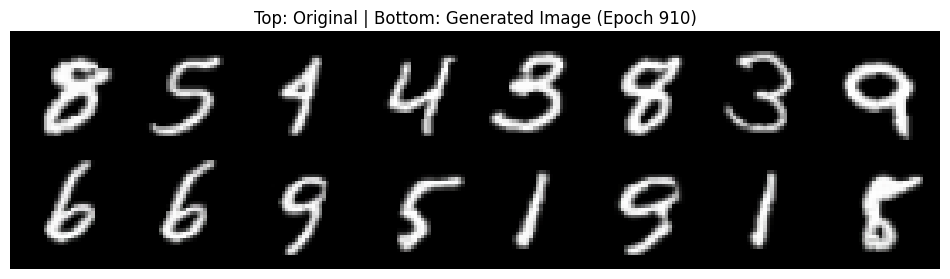

Epoch-911/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=3.88, DisLoss=0.275, DisSteps=1]


Generator Loss: 4.296126661778513
Discriminator Loss: 0.20807289829386322


Epoch-912/1000: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s, GenLoss=3.66, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.8403813274684495
Discriminator Loss: 0.19709762524185911


Epoch-913/1000: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s, GenLoss=4.88, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.104887718839178
Discriminator Loss: 0.2037643060755374


Epoch-914/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=4.29, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.026869592381947
Discriminator Loss: 0.2230125026408035


Epoch-915/1000: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s, GenLoss=5.07, DisLoss=0.219, DisSteps=1]


Generator Loss: 4.282705442229314
Discriminator Loss: 0.20152689700823095


Epoch-916/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, GenLoss=4.82, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.208714733499962
Discriminator Loss: 0.21606903909238925


Epoch-917/1000: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s, GenLoss=3.9, DisLoss=0.368, DisSteps=1] 


Generator Loss: 4.236237968208948
Discriminator Loss: 0.2043648016478207


Epoch-918/1000: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s, GenLoss=4.54, DisLoss=0.264, DisSteps=1] 


Generator Loss: 3.9437318704784046
Discriminator Loss: 0.22075824226651872


Epoch-919/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s, GenLoss=4.19, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.345997882296027
Discriminator Loss: 0.20344890863783577


Epoch-920/1000: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s, GenLoss=3.56, DisLoss=0.206, DisSteps=1]


Generator Loss: 4.250965795028947
Discriminator Loss: 0.20872448839104252


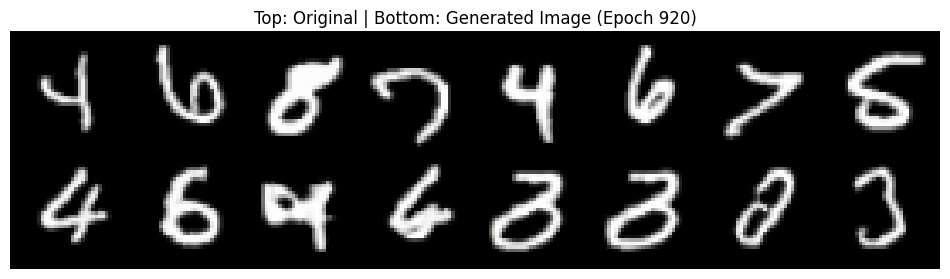

Epoch-921/1000: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s, GenLoss=5.52, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.268065053516868
Discriminator Loss: 0.20938121303439394


Epoch-922/1000: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s, GenLoss=4.08, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.5881981282854385
Discriminator Loss: 0.20229393679068794


Epoch-923/1000: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s, GenLoss=4.06, DisLoss=0.193, DisSteps=1]


Generator Loss: 4.339315825179696
Discriminator Loss: 0.20461674358671916


Epoch-924/1000: 100%|██████████| 469/469 [00:29<00:00, 15.76it/s, GenLoss=4.21, DisLoss=0.21, DisSteps=1] 


Generator Loss: 4.414042694736391
Discriminator Loss: 0.20570776098445534


Epoch-925/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s, GenLoss=3.53, DisLoss=0.227, DisSteps=1]


Generator Loss: 4.560797013199406
Discriminator Loss: 0.20743987015061288


Epoch-926/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s, GenLoss=4.18, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.529963551808014
Discriminator Loss: 0.19667552653024953


Epoch-927/1000: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s, GenLoss=3.22, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.567495113496841
Discriminator Loss: 0.19626668816817594


Epoch-928/1000: 100%|██████████| 469/469 [00:29<00:00, 15.94it/s, GenLoss=4.28, DisLoss=0.521, DisSteps=1]


Generator Loss: 4.5821393685046035
Discriminator Loss: 0.19658936893762047


Epoch-929/1000: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s, GenLoss=5.25, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.611689968912332
Discriminator Loss: 0.1944097456838022


Epoch-930/1000: 100%|██████████| 469/469 [00:29<00:00, 15.80it/s, GenLoss=4.81, DisLoss=0.306, DisSteps=1]


Generator Loss: 4.464459425859106
Discriminator Loss: 0.1990509402396074


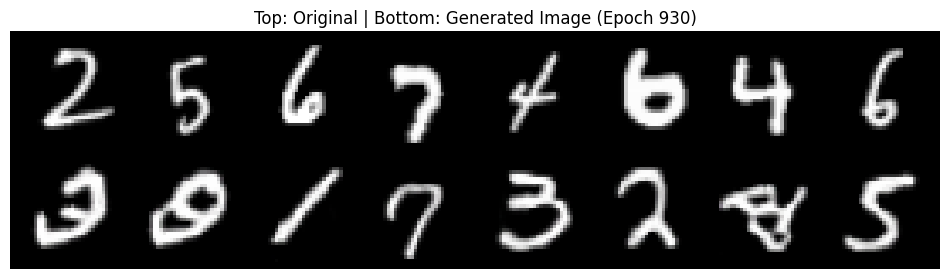

Epoch-931/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, GenLoss=4.99, DisLoss=0.187, DisSteps=1]


Generator Loss: 5.038236692770203
Discriminator Loss: 0.19170501583547733


Epoch-932/1000: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s, GenLoss=5.25, DisLoss=0.374, DisSteps=1]


Generator Loss: 4.928442002867839
Discriminator Loss: 0.19601711211428205


Epoch-933/1000: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s, GenLoss=4.48, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.748105180288937
Discriminator Loss: 0.19696562297181533


Epoch-934/1000: 100%|██████████| 469/469 [00:29<00:00, 15.86it/s, GenLoss=6.14, DisLoss=0.245, DisSteps=1]


Generator Loss: 4.847431439072339
Discriminator Loss: 0.19100013451535564


Epoch-935/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s, GenLoss=4.7, DisLoss=0.188, DisSteps=1] 


Generator Loss: 4.46630677053415
Discriminator Loss: 0.204680915040248


Epoch-936/1000: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s, GenLoss=4.06, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.054238162315222
Discriminator Loss: 0.2097380052942203


Epoch-937/1000: 100%|██████████| 469/469 [00:30<00:00, 15.13it/s, GenLoss=6.45, DisLoss=0.213, DisSteps=1]


Generator Loss: 4.677642764058957
Discriminator Loss: 0.20141817022488315


Epoch-938/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s, GenLoss=3.66, DisLoss=0.234, DisSteps=1]


Generator Loss: 4.303068527280649
Discriminator Loss: 0.20864470083830453


Epoch-939/1000: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s, GenLoss=5.54, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.216187116433817
Discriminator Loss: 0.21191046236039224


Epoch-940/1000: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s, GenLoss=3.92, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.280199920190677
Discriminator Loss: 0.21266033568743195


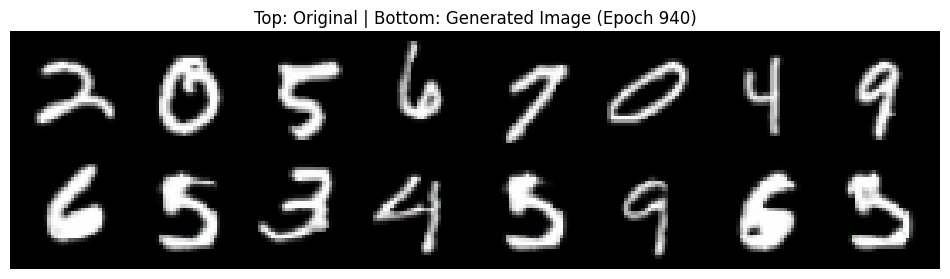

Epoch-941/1000: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s, GenLoss=2.92, DisLoss=0.222, DisSteps=1]


Generator Loss: 4.233053987976839
Discriminator Loss: 0.20979646410642147


Epoch-942/1000: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s, GenLoss=4.11, DisLoss=0.238, DisSteps=1]


Generator Loss: 4.357574041972536
Discriminator Loss: 0.20184020358108


Epoch-943/1000: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s, GenLoss=5.74, DisLoss=0.232, DisSteps=1]


Generator Loss: 4.705909559721632
Discriminator Loss: 0.19954668944959703


Epoch-944/1000: 100%|██████████| 469/469 [00:30<00:00, 15.38it/s, GenLoss=5.12, DisLoss=0.202, DisSteps=1]


Generator Loss: 4.491065641964422
Discriminator Loss: 0.20129176300725957


Epoch-945/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, GenLoss=2.65, DisLoss=0.3, DisSteps=1]  


Generator Loss: 4.568104193154682
Discriminator Loss: 0.19748737836189106


Epoch-946/1000: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s, GenLoss=3.24, DisLoss=0.261, DisSteps=1]


Generator Loss: 4.406415335913457
Discriminator Loss: 0.20405603741913209


Epoch-947/1000: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, GenLoss=6.81, DisLoss=0.242, DisSteps=1]


Generator Loss: 4.473953794823018
Discriminator Loss: 0.20642932226408772


Epoch-948/1000: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s, GenLoss=3.58, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.384589983710348
Discriminator Loss: 0.2055748483138298


Epoch-949/1000: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s, GenLoss=4.19, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.202886089333085
Discriminator Loss: 0.21469634002459836


Epoch-950/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, GenLoss=3.51, DisLoss=0.231, DisSteps=1]


Generator Loss: 4.464562731256871
Discriminator Loss: 0.20843138448846366


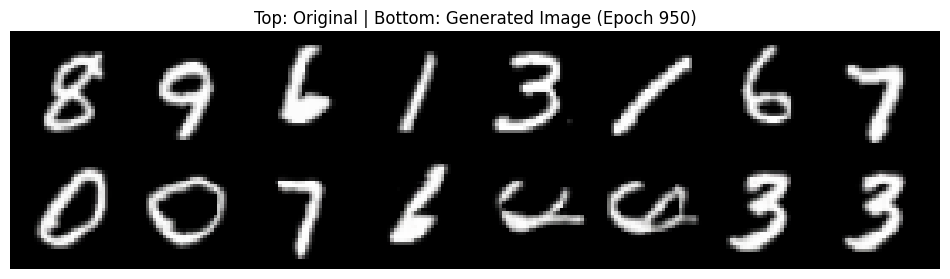

Epoch-951/1000: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s, GenLoss=4.79, DisLoss=0.184, DisSteps=1]


Generator Loss: 4.624824691174635
Discriminator Loss: 0.20079091121392972


Epoch-952/1000: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s, GenLoss=6.9, DisLoss=0.172, DisSteps=1] 


Generator Loss: 4.594534788050377
Discriminator Loss: 0.20170789791831076


Epoch-953/1000: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s, GenLoss=5.23, DisLoss=0.171, DisSteps=1]


Generator Loss: 4.849640166327389
Discriminator Loss: 0.19873155907654305


Epoch-954/1000: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s, GenLoss=6.21, DisLoss=0.171, DisSteps=1]


Generator Loss: 5.226507024215991
Discriminator Loss: 0.18971261166052014


Epoch-955/1000: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s, GenLoss=6.44, DisLoss=0.169, DisSteps=1]


Generator Loss: 5.102433831452815
Discriminator Loss: 0.19002096631379525


Epoch-956/1000: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s, GenLoss=2.21, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.698042645891592
Discriminator Loss: 0.18918711769936689


Epoch-957/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s, GenLoss=4.79, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.84655652574893
Discriminator Loss: 0.19290852200374928


Epoch-958/1000: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s, GenLoss=4.15, DisLoss=0.194, DisSteps=1]


Generator Loss: 4.996057035572239
Discriminator Loss: 0.19224541407149992


Epoch-959/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, GenLoss=5.58, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.593743726134554
Discriminator Loss: 0.2079857313937978


Epoch-960/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s, GenLoss=5.5, DisLoss=0.183, DisSteps=1] 


Generator Loss: 4.684986803577399
Discriminator Loss: 0.19631752775294947


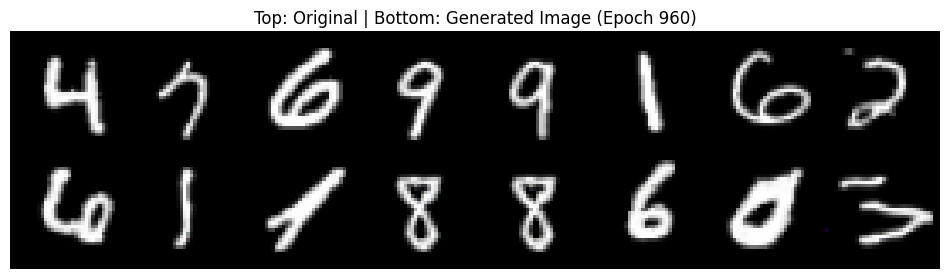

Epoch-961/1000: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s, GenLoss=3.55, DisLoss=0.194, DisSteps=1]


Generator Loss: 4.816777758506824
Discriminator Loss: 0.19262416683026215


Epoch-962/1000: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, GenLoss=3.87, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.702114292553493
Discriminator Loss: 0.19968321334832767


Epoch-963/1000: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s, GenLoss=3.62, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.572695316282163
Discriminator Loss: 0.1990887298703448


Epoch-964/1000: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s, GenLoss=4.47, DisLoss=0.215, DisSteps=1]


Generator Loss: 4.794590554766055
Discriminator Loss: 0.20133970754105907


Epoch-965/1000: 100%|██████████| 469/469 [00:34<00:00, 13.53it/s, GenLoss=4.2, DisLoss=0.181, DisSteps=1] 


Generator Loss: 4.938236728660079
Discriminator Loss: 0.19652163219858587


Epoch-966/1000: 100%|██████████| 469/469 [00:34<00:00, 13.47it/s, GenLoss=3.49, DisLoss=0.195, DisSteps=1]


Generator Loss: 4.525772165387933
Discriminator Loss: 0.19721588187380387


Epoch-967/1000: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s, GenLoss=4.27, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.564973406700183
Discriminator Loss: 0.1946437561562829


Epoch-968/1000: 100%|██████████| 469/469 [00:33<00:00, 13.85it/s, GenLoss=4.22, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.865305409502628
Discriminator Loss: 0.1917802096048652


Epoch-969/1000: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s, GenLoss=2.69, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.842356139408754
Discriminator Loss: 0.19856080095142697


Epoch-970/1000: 100%|██████████| 469/469 [00:34<00:00, 13.57it/s, GenLoss=6.2, DisLoss=0.187, DisSteps=1] 


Generator Loss: 5.0197607952394465
Discriminator Loss: 0.1943782579733619


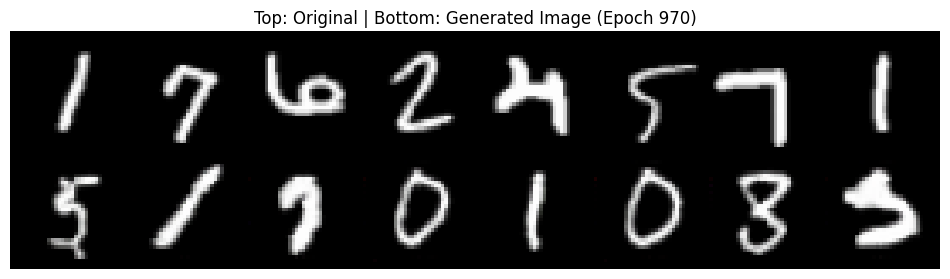

Epoch-971/1000: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s, GenLoss=5.82, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.624925464963608
Discriminator Loss: 0.19896728807547961


Epoch-972/1000: 100%|██████████| 469/469 [00:35<00:00, 13.18it/s, GenLoss=5.66, DisLoss=0.649, DisSteps=1]


Generator Loss: 4.523029241226375
Discriminator Loss: 0.20451353198048403


Epoch-973/1000: 100%|██████████| 469/469 [00:35<00:00, 13.40it/s, GenLoss=4.8, DisLoss=0.192, DisSteps=1] 


Generator Loss: 4.598890073009645
Discriminator Loss: 0.20007918349334172


Epoch-974/1000: 100%|██████████| 469/469 [00:35<00:00, 13.31it/s, GenLoss=5.25, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.457183166353433
Discriminator Loss: 0.19561407052631827


Epoch-975/1000: 100%|██████████| 469/469 [00:35<00:00, 13.29it/s, GenLoss=5.7, DisLoss=0.188, DisSteps=1] 


Generator Loss: 4.443704474963613
Discriminator Loss: 0.20218812005479198


Epoch-976/1000: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s, GenLoss=5.56, DisLoss=0.176, DisSteps=1]


Generator Loss: 4.413047009439611
Discriminator Loss: 0.19874288287879563


Epoch-977/1000: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s, GenLoss=3.92, DisLoss=0.178, DisSteps=1]


Generator Loss: 4.499752945737289
Discriminator Loss: 0.2024949474820196


Epoch-978/1000: 100%|██████████| 469/469 [00:34<00:00, 13.59it/s, GenLoss=5.12, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.976232399818485
Discriminator Loss: 0.19244065331116414


Epoch-979/1000: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s, GenLoss=5.64, DisLoss=0.224, DisSteps=1]


Generator Loss: 4.88139071800053
Discriminator Loss: 0.19246409483937058


Epoch-980/1000: 100%|██████████| 469/469 [00:37<00:00, 12.57it/s, GenLoss=3.67, DisLoss=0.217, DisSteps=1]


Generator Loss: 4.67652844162638
Discriminator Loss: 0.19595296798484413


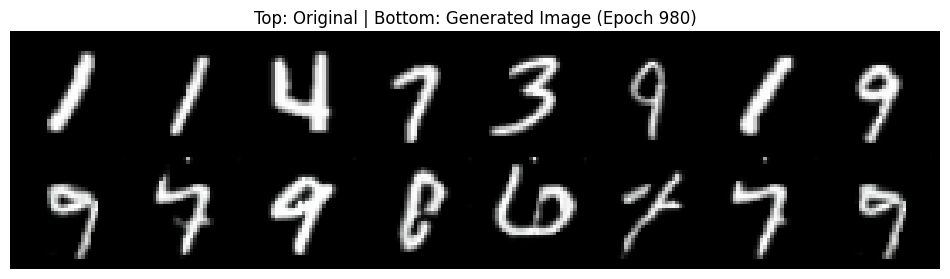

Epoch-981/1000: 100%|██████████| 469/469 [00:35<00:00, 13.34it/s, GenLoss=6.3, DisLoss=0.174, DisSteps=1] 


Generator Loss: 4.398652017243635
Discriminator Loss: 0.20229875577538253


Epoch-982/1000: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s, GenLoss=4.19, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.3241454878849765
Discriminator Loss: 0.19993470316883852


Epoch-983/1000: 100%|██████████| 469/469 [00:34<00:00, 13.67it/s, GenLoss=4.64, DisLoss=0.181, DisSteps=1]


Generator Loss: 4.399392531624735
Discriminator Loss: 0.20611610500288924


Epoch-984/1000: 100%|██████████| 469/469 [00:35<00:00, 13.31it/s, GenLoss=4.23, DisLoss=0.275, DisSteps=1]


Generator Loss: 4.237728642756497
Discriminator Loss: 0.2052168061992507


Epoch-985/1000: 100%|██████████| 469/469 [00:34<00:00, 13.66it/s, GenLoss=6.52, DisLoss=0.232, DisSteps=1]


Generator Loss: 4.234137940000116
Discriminator Loss: 0.2121683832234157


Epoch-986/1000: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s, GenLoss=2.47, DisLoss=0.248, DisSteps=1]


Generator Loss: 4.3799920666700745
Discriminator Loss: 0.20579399133541945


Epoch-987/1000: 100%|██████████| 469/469 [00:40<00:00, 11.61it/s, GenLoss=3.87, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.261712089784618
Discriminator Loss: 0.2043699594194701


Epoch-988/1000: 100%|██████████| 469/469 [01:12<00:00,  6.47it/s, GenLoss=4.75, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.250218671013806
Discriminator Loss: 0.20815739518543805


Epoch-989/1000: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s, GenLoss=3.98, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.382538420813424
Discriminator Loss: 0.2041893422222341


Epoch-990/1000: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s, GenLoss=3.83, DisLoss=0.324, DisSteps=1]


Generator Loss: 4.061904988563391
Discriminator Loss: 0.21240107969307442


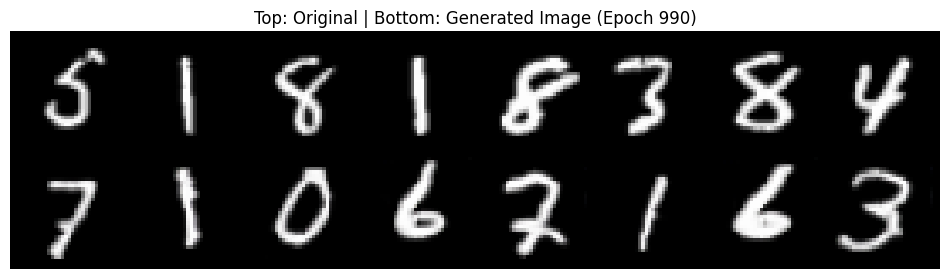

Epoch-991/1000: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s, GenLoss=3.47, DisLoss=0.175, DisSteps=1]


Generator Loss: 4.453693823773723
Discriminator Loss: 0.2004511994021788


Epoch-992/1000: 100%|██████████| 469/469 [00:47<00:00,  9.77it/s, GenLoss=4.37, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.3029715521757534
Discriminator Loss: 0.2078219043420576


Epoch-993/1000: 100%|██████████| 469/469 [00:41<00:00, 11.38it/s, GenLoss=3.73, DisLoss=0.185, DisSteps=1]


Generator Loss: 4.180524197468626
Discriminator Loss: 0.21119857905134717


Epoch-994/1000: 100%|██████████| 469/469 [00:41<00:00, 11.36it/s, GenLoss=5.13, DisLoss=0.189, DisSteps=1]


Generator Loss: 4.362264718328204
Discriminator Loss: 0.20998095442999654


Epoch-995/1000: 100%|██████████| 469/469 [00:39<00:00, 11.79it/s, GenLoss=4.98, DisLoss=0.177, DisSteps=1]


Generator Loss: 4.206089548718955
Discriminator Loss: 0.20468659355823418


Epoch-996/1000: 100%|██████████| 469/469 [00:41<00:00, 11.20it/s, GenLoss=6.71, DisLoss=0.221, DisSteps=1]


Generator Loss: 4.284387413626795
Discriminator Loss: 0.203542520846131


Epoch-997/1000: 100%|██████████| 469/469 [00:42<00:00, 10.97it/s, GenLoss=3.98, DisLoss=0.183, DisSteps=1]


Generator Loss: 4.357929122727563
Discriminator Loss: 0.20506626818734192


Epoch-998/1000: 100%|██████████| 469/469 [00:47<00:00,  9.90it/s, GenLoss=8.22, DisLoss=0.172, DisSteps=1]


Generator Loss: 4.671238366983085
Discriminator Loss: 0.20223841239521498


Epoch-999/1000: 100%|██████████| 469/469 [00:39<00:00, 11.76it/s, GenLoss=6.73, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.479023002866489
Discriminator Loss: 0.20430426728496673


Epoch-1000/1000: 100%|██████████| 469/469 [00:39<00:00, 11.75it/s, GenLoss=5.58, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.400924161044774
Discriminator Loss: 0.20175559907706817


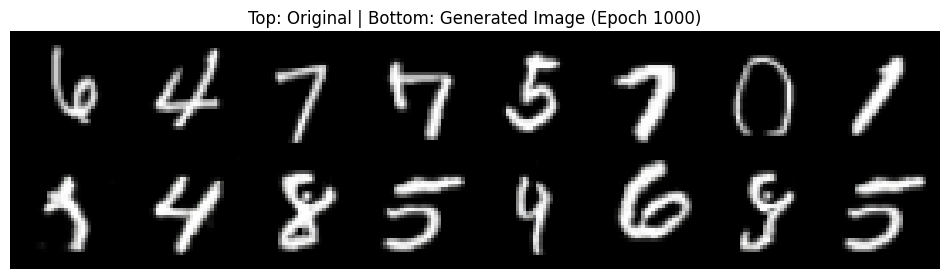

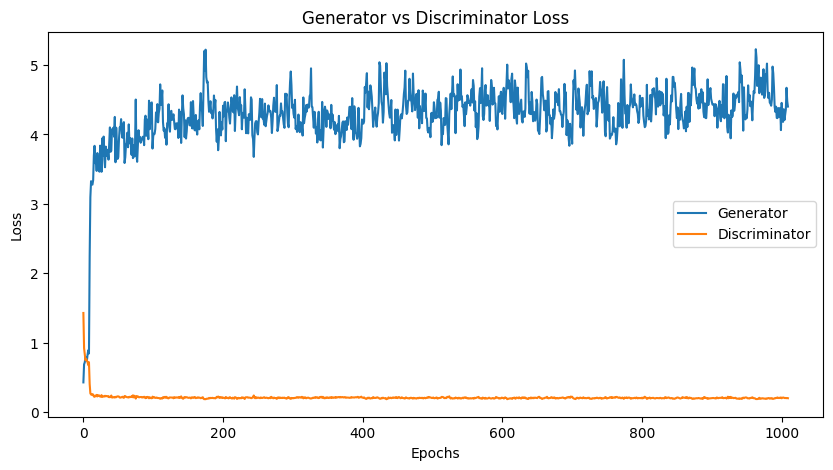

In [ ]:
# epochs=1000
# warmup_epochs = 10
# dis_schedule = np.linspace(5, 1, num=warmup_epochs)
# DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# gan_model = GANModel()
# gan_model = gan_model.to(DEVICE)
# opt_gen = torch.optim.Adam(gan_model.generator.parameters(), lr=1e-4)
# opt_dis = torch.optim.Adam(gan_model.discriminator.parameters(), lr=1e-4)
# train_dataset = MNISTCSV("/scratch/s25090/archive/mnist/mnist_train.csv")
# test_dataset = MNISTCSV("/scratch/s25090/archive/mnist/mnist_test.csv")
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# # l1_loss = nn.L1Loss()

# # gen_loss_list = []
# # dis_loss_list = []

# for epoch in range(epochs):
#     tot_gen_loss = 0
#     tot_dis_loss = 0
#     gan_model.train()
#     tqdm_data = tqdm(train_loader, desc=f"Epoch-{epoch+1}/{epochs}")
#     dis_steps = ceil(dis_schedule[epoch]) if epoch+1 < warmup_epochs else 1
#     i=0
#     for real_img, _ in tqdm_data:
#         i+=1
#         real_img = real_img.to(DEVICE)
#         bs = real_img.size(0)
#         if i%dis_steps==0:
#             z_dis = torch.randn(bs, 100).to(DEVICE)
#             opt_dis.zero_grad()
#             dis_loss = gan_model.compute_discriminator_loss(real_img, z_dis)
#             dis_loss.backward()
#             opt_dis.step()
#         else:
#             dis_loss = torch.tensor(0.0).to(DEVICE)

#         for param in gan_model.discriminator.parameters():
#             param.requires_grad = False

#         z = torch.randn(bs, 100).to(DEVICE)
#         opt_gen.zero_grad()
#         gen_loss, fake_img = gan_model.compute_generator_loss(z)
#         gen_loss.backward()
#         opt_gen.step()

#         tot_gen_loss+=gen_loss.detach().cpu().item()
#         tot_dis_loss+=dis_loss.detach().cpu().item()
#         tqdm_data.set_postfix({
#             "GenLoss":gen_loss.detach().cpu().item(),
#             "DisLoss":dis_loss.detach().cpu().item(),
#             "DisSteps":dis_steps
#         })

#         for param in gan_model.discriminator.parameters():
#             param.requires_grad = True

    
#     gen_loss_list.append(tot_gen_loss/len(train_loader))
#     dis_loss_list.append(tot_dis_loss*dis_steps/len(train_loader))

#     print(f"Generator Loss: {gen_loss_list[-1]}\nDiscriminator Loss: {dis_loss_list[-1]}")

#     if (epoch + 1) % 10 == 0:
#         torch.save(gan_model.state_dict(), f'/scratch/s25090/gan_outputs/weights/Experiment_mnist/gan_epoch_{epoch+1}.pth')
#         gan_model.eval()
#         with torch.no_grad():
#             gan_image = gan_model(z)
#             comparison = torch.cat([real_img[:8], gan_image[:8]], dim=0)
#             grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
#             plt.figure(figsize=(12, 4))
#             plt.imshow(grid.permute(1, 2, 0))
#             plt.axis('off')
#             plt.title(f'Top: Original | Bottom: Generated Image (Epoch {epoch+1})')
#             plt.savefig(f"/scratch/s25090/gan_outputs/plots/Experiment_mnist/Epoch-{epoch+1}.png")
#             plt.show()
#             plt.close()

# plt.figure(figsize=(10, 5))
# plt.title("Generator vs Discriminator Loss")
# plt.plot(gen_loss_list, label="Generator")
# plt.plot(dis_loss_list, label="Discriminator")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.savefig(f"/scratch/s25090/gan_outputs/plots/Experiment_mnist.png")
# plt.legend()
# plt.show()

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
gan_model = GANModel()
gan_model = gan_model.to(DEVICE)
WEIGHT = torch.load("gan_outputs/mnist_gan.pth")
gan_model.load_state_dict(WEIGHT)
test_loader = DataLoader(MNISTCSV("/scratch/s25090/archive/mnist/mnist_test.csv"), batch_size=128, shuffle=False)

In [7]:
def get_evaluation_metrics(generator, dataloader, device, num_imgs=10000):
    """
    Calculates FID and IS for a GAN generator.
    
    Args:
        generator: The GAN generator model.
        dataloader: DataLoader for real images (needed for FID reference).
        device: 'cuda' or 'cpu'.
        num_imgs: Number of images to generate/use for calculation.
                  (Standard for papers is 50k, but 10k is faster for debugging).
    
    Returns:
        fid_score (float), is_score (float)
    """
    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    inception = InceptionScore(normalize=True).to(device)
    
    generator.eval()
    
    print(f"--- Computing Metrics (Samples: {num_imgs}) ---")
    
    real_count = 0
    for batch, _ in tqdm(dataloader, desc="Processing Real Images"):
        batch = batch.to(device)
        remaining = num_imgs - real_count
        if remaining <= 0:
            break
            
        if batch.shape[0] > remaining:
            batch = batch[:remaining]
        if batch.min() < 0:
            batch = (batch + 1) / 2  # Now [0, 1]
            
        fid.update((batch * 255).to(torch.uint8), real=True)
        real_count += batch.shape[0]

    fake_count = 0
    while fake_count < num_imgs:
        batch_size = min(dataloader.batch_size, num_imgs - fake_count)
        
        z = torch.randn(batch_size, 100).to(device)
        
        with torch.no_grad():
            fake_imgs = generator(z)
        fake_imgs = (fake_imgs + 1) / 2
        fake_uint8 = (fake_imgs * 255).to(torch.uint8)
        
        fid.update(fake_uint8, real=False)
        inception.update(fake_uint8)
        
        fake_count += batch_size
        
    print("Finalizing calculations...")
    fid_score = fid.compute().item()
    is_score_mean, is_score_std = inception.compute()
    
    return fid_score, is_score_mean.item()

fid, is_score = get_evaluation_metrics(
    gan_model.generator, 
    test_loader, 
    DEVICE, 
    num_imgs=2000
)
print(f"FID: {fid:.4f} | IS: {is_score:.4f}")

--- Computing Metrics (Samples: 2000) ---


Processing Real Images:  20%|██        | 16/79 [00:02<00:10,  6.27it/s]


Finalizing calculations...
FID: 38.1343 | IS: 1.7069
